#### 1. Multilayer Perceptron (MLP)

In [8]:
# Step 1: Import Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

In [9]:
#Step 2: Load the Dataset
# Load the scaled dataset
data = pd.read_csv('balanced_dataset.csv')
data.head()

,Age,Arrival Service,Booking Services,Immediate Transfer,Lounge Service,Check-in Service,Boarding Service,Layover Service,Onboard Services,Baggage Service,...,Arrival Delay,Total Delay,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal,Class_Eco,Class_Leisure,Satisfaction_Satisfied,Unnamed: 21,Unnamed: 22
0,1.296579,0.707066,-0.725397,-0.707346,-1.415134,0.710901,-0.724658,1.419690,-0.713449,1.426085,...,-0.422668,-0.503673,False,False,False,False,False,1,NaN,NaN
1,0.370184,1.410824,-1.432411,-0.000954,-0.000071,0.007665,-1.432021,0.007274,-0.004924,1.426085,...,82.010552,49.503660,False,False,False,False,False,1,NaN,NaN
2,0.298923,0.003308,-1.432411,-1.413738,0.707461,0.710901,-0.017295,0.007274,-0.004924,1.426085,...,-0.422668,-0.503673,True,False,False,True,False,1,NaN,NaN
3,-0.057383,1.410824,-1.432411,-0.707346,1.414992,-1.398805,0.690068,-0.698934,-0.713449,0.718877,...,-0.422668,-0.503673,False,False,False,False,False,1,NaN,NaN
4,0.940273,1.410824,-0.018382,-1.413738,1.414992,-0.695570,0.690068,1.419690,-1.421974,-0.695539,...,-0.422668,-0.503673,True,False,False,False,False,1,NaN,NaN


In [10]:
data.shape

(29990, 23)

In [11]:
# Separate features and target
X = data.drop('Satisfaction_Satisfied', axis=1) 
y = data['Satisfaction_Satisfied']  

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ====== DATA PREPROCESSING ======
print("\n=== Data Check ===")
print(f"Initial X shape: {X.shape}, y shape: {y.shape}")
print(f"Initial dtypes:\n{X.dtypes}")

# Convert all columns to numeric, coercing errors to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Drop columns that couldn't be converted to numeric
X = X.dropna(axis=1, how='all')

# Fill remaining NaN values with column mean
X = X.fillna(X.mean())

# Remove constant features
non_constant_cols = X.std(axis=0) > 0
X = X.loc[:, non_constant_cols]

# Ensure y is numeric
y = pd.to_numeric(y, errors='coerce')
y = y.fillna(0).astype('int32')  # Assuming binary classification (0/1)

print(f"\nProcessed X shape: {X.shape}")
print(f"Processed y distribution:\n{pd.Series(y).value_counts()}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


=== Data Check ===
Initial X shape: (29990, 20), y shape: (29990,)
Initial dtypes:
Age                                float64
Arrival Service                    float64
Booking Services                   float64
Immediate Transfer                 float64
Lounge Service                     float64
Check-in Service                   float64
Boarding Service                   float64
Layover Service                    float64
Onboard Services                   float64
Baggage Service                    float64
Immigration Security               float64
Call Center Service                float64
Departure Delay                    float64
Arrival Delay                      float64
Total Delay                        float64
Gender_Male                           bool
Customer Type_disloyal Customer       bool
Type of Travel_Personal               bool
Class_Eco                             bool
Class_Leisure                         bool
dtype: object

Processed X shape: (29990, 20)
Processed 

In [ ]:
# ====== MODEL BUILDING ======

# Create a Sequential model (linear stack of layers)
model = Sequential([
    
    # First hidden layer with 64 neurons and ReLU activation
    # input_shape specifies the number of features in the input data
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    
    # Batch normalization layer to normalize activations from previous layer
    # Helps stabilize and accelerate training
    BatchNormalization(),
    
    # Dropout layer randomly sets 30% of input units to 0 during training
    # Helps prevent overfitting by introducing noise
    Dropout(0.3),
    
    # Second hidden layer with 32 neurons and ReLU activation
    Dense(32, activation='relu'),
    
    # Another batch normalization layer
    BatchNormalization(),
    
    # Output layer with 1 neuron and sigmoid activation
    # Sigmoid outputs probability between 0 and 1 for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model to configure the learning process
model.compile(
    # Use Adam optimizer with learning rate 0.001
    # Adam is an adaptive learning rate optimization algorithm
    optimizer=Adam(learning_rate=0.001),
    
    # Use binary crossentropy loss function
    # Appropriate for binary classification problems
    loss='binary_crossentropy',
    
    # Track accuracy metric during training
    metrics=['accuracy']
)

In [ ]:
# ====== TRAINING ======

# Set up EarlyStopping callback to monitor validation loss
# Will stop training if val_loss doesn't improve for 10 consecutive epochs
# restore_best_weights=True ensures we keep the best model weights
early_stop = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (validation loss)
    patience=10,        # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore weights from best epoch
)

# Train the model using fit() method
history = model.fit(
    # Training data features (input)
    X_train, 
    # Training data labels (target)
    y_train,
    # Maximum number of training epochs
    epochs=100,
    # Number of samples per gradient update
    batch_size=32,
    # Fraction of training data to use for validation
    validation_split=0.2,
    # Verbosity mode (1 = progress bar)
    verbose=1,
    # List of callbacks to apply during training
    callbacks=[early_stop]  # Using our EarlyStopping callback
)

# The history object contains:
# - Training metrics (loss, accuracy) per epoch
# - Validation metrics (val_loss, val_accuracy) per epoch
# This data can be used for visualization and analysis

Epoch 1/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7576 - loss: 0.5273 - val_accuracy: 0.8391 - val_loss: 0.3987
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8217 - loss: 0.4312 - val_accuracy: 0.8391 - val_loss: 0.3939
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8366 - loss: 0.4080 - val_accuracy: 0.8423 - val_loss: 0.3909
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8299 - loss: 0.4141 - val_accuracy: 0.8450 - val_loss: 0.3858
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8324 - loss: 0.4054 - val_accuracy: 0.8473 - val_loss: 0.3848
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8375 - loss: 0.3989 - val_accuracy: 0.8485 - val_loss: 0.3840
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8396 - loss: 0.3984 - val_accuracy: 0.8462 - val_loss: 0.3815
Epoch 8/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8397 - loss: 0.4027 - val_accu

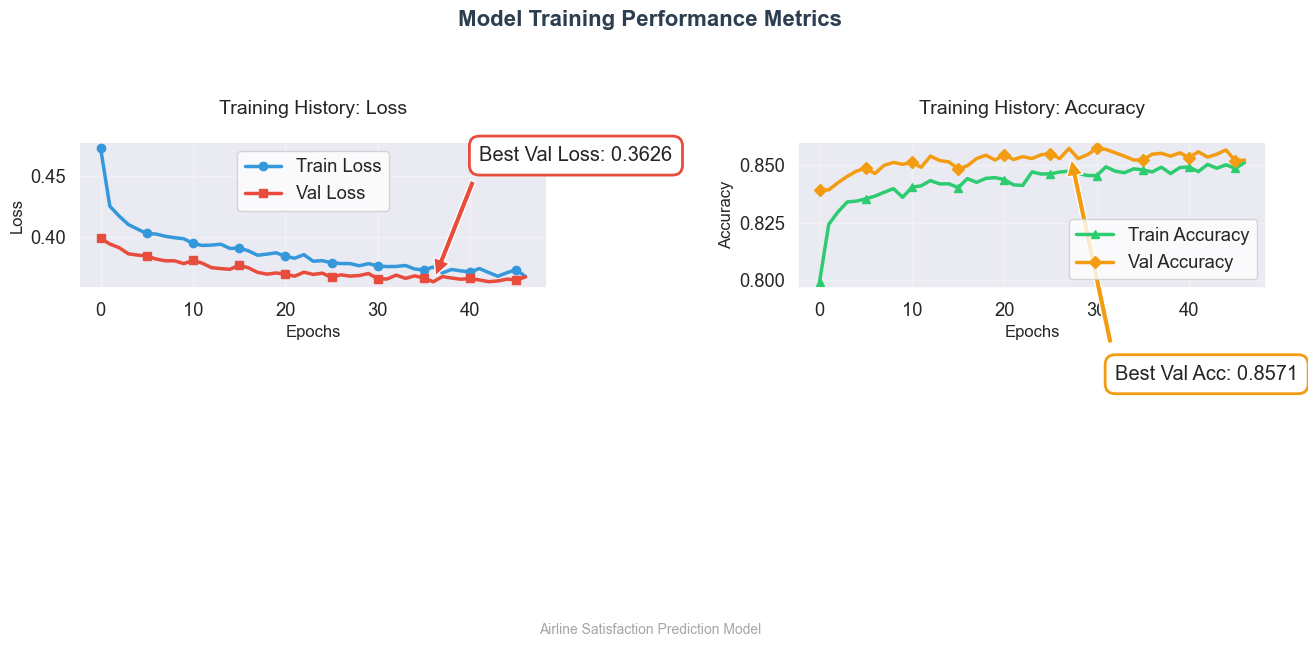

In [25]:
# ====== ENHANCED EVALUATION VISUALIZATION ======
#plt.style.use('whitegrid')
plt.figure(figsize=(14, 6))

# Custom color palette
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

# 1. Training History Plot
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history.history['loss'], color=colors[0], linewidth=2.5, 
        label='Train Loss', marker='o', markersize=6, markevery=5)
ax1.plot(history.history['val_loss'], color=colors[1], linewidth=2.5,
        label='Val Loss', marker='s', markersize=6, markevery=5)
ax1.set_title('Training History: Loss', fontsize=14, pad=20)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(frameon=True, facecolor='white')
ax1.grid(True, alpha=0.3)

# Add annotation for best validation loss
min_val_loss = min(history.history['val_loss'])
min_val_epoch = history.history['val_loss'].index(min_val_loss)
ax1.annotate(f'Best Val Loss: {min_val_loss:.4f}',
            xy=(min_val_epoch, min_val_loss),
            xytext=(min_val_epoch+5, min_val_loss+0.1),
            arrowprops=dict(facecolor=colors[1], shrink=0.05),
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec=colors[1], lw=2))

# 2. Accuracy History Plot
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history.history['accuracy'], color=colors[2], linewidth=2.5,
        label='Train Accuracy', marker='^', markersize=6, markevery=5)
ax2.plot(history.history['val_accuracy'], color=colors[3], linewidth=2.5,
        label='Val Accuracy', marker='D', markersize=6, markevery=5)
ax2.set_title('Training History: Accuracy', fontsize=14, pad=20)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(frameon=True, facecolor='white')
ax2.grid(True, alpha=0.3)

# Add annotation for best validation accuracy
max_val_acc = max(history.history['val_accuracy'])
max_val_epoch = history.history['val_accuracy'].index(max_val_acc)
ax2.annotate(f'Best Val Acc: {max_val_acc:.4f}',
            xy=(max_val_epoch, max_val_acc),
            xytext=(max_val_epoch+5, max_val_acc-0.1),
            arrowprops=dict(facecolor=colors[3], shrink=0.05),
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec=colors[3], lw=2))

plt.tight_layout(pad=3.0)

# Add overall title
plt.suptitle('Model Training Performance Metrics', y=1.05, 
            fontsize=16, fontweight='bold', color='#2c3e50')

# Add watermark
plt.figtext(0.5, 0.01, "Airline Satisfaction Prediction Model", 
           ha='center', fontsize=10, color='gray', alpha=0.7)

plt.show()

In [ ]:
# ====== THRESHOLD OPTIMIZATION & EVALUATION ======

# Generate predicted probabilities for validation set (first 20% of training data)
# This uses the hold-out portion from validation_split during training
val_pred_prob = model.predict(
    X_train[:int(0.2 * len(X_train))]  # Take first 20% of training data
)  # Outputs probabilities between 0 and 1

# Calculate ROC curve metrics using validation predictions:
# fpr = False Positive Rate
# tpr = True Positive Rate (Recall)
# thresholds = All probability thresholds used
fpr, tpr, thresholds = roc_curve(
    y_train[:int(0.2 * len(X_train))],  # True labels for validation set
    val_pred_prob  # Predicted probabilities
)

# Find optimal threshold using Youden's J statistic:
# Maximizes (True Positive Rate - False Positive Rate)
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Print the optimal threshold with 4 decimal precision
print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
# (This threshold balances precision and recall)

# ====== FINAL EVALUATION ======

# Generate predicted probabilities for test set
y_pred_prob = model.predict(X_test)  # Outputs probabilities for test data

# Convert probabilities to binary predictions using optimal threshold:
# 1 if probability > threshold, else 0
y_pred = (y_pred_prob > optimal_threshold).astype('int32') 
# astype('int32') ensures integer output for classification metrics

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Optimal Threshold: 0.5172
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [19]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Dissatisfied', 'Satisfied']))


Classification Report:
              precision    recall  f1-score   support

Dissatisfied       0.85      0.85      0.85      2999
   Satisfied       0.85      0.85      0.85      2999

    accuracy                           0.85      5998
   macro avg       0.85      0.85      0.85      5998
weighted avg       0.85      0.85      0.85      5998



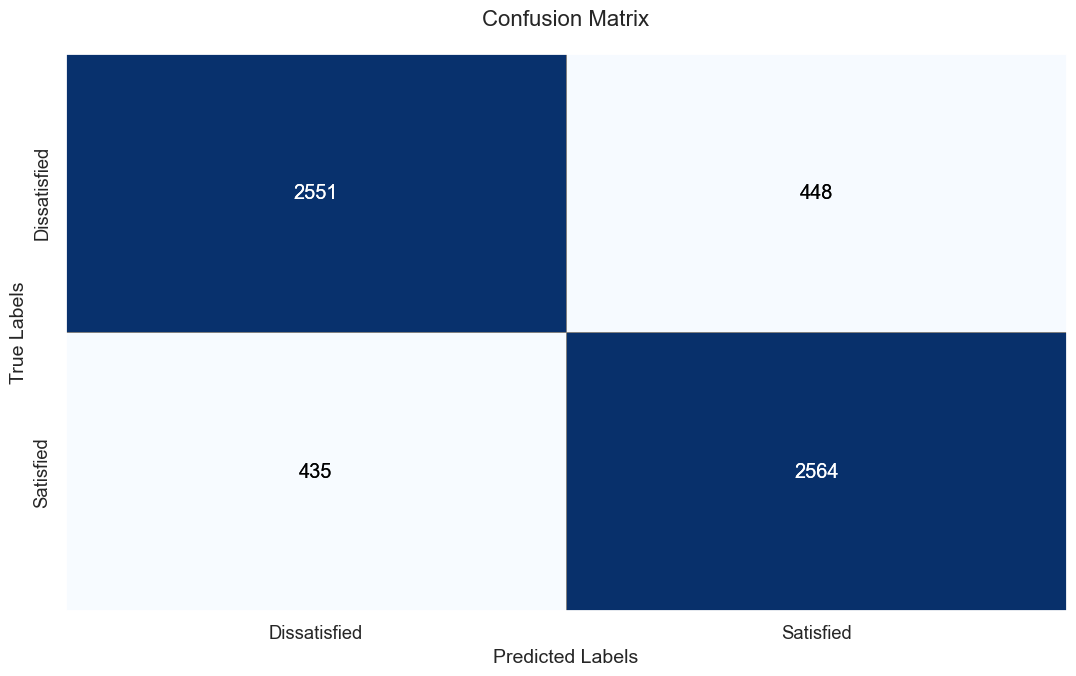


Enhanced Confusion Matrix:
+---------------------------------+
|           | Predicted          |
|           +----------+----------+
| True      | Dissatisfied | Satisfied |
+---------------------------------+
| Dissatisfied |    2551     |    448    |
+---------------------------------+
| Satisfied    |     435     |   2564    |
+---------------------------------+

Key Metrics:
• Accuracy:  85.28%
• Precision: 85.13%
• Recall:    85.50%
• F1 Score:  85.31%


In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create beautiful visualization
plt.figure(figsize=(11, 7))
sns.set(font_scale=1.2)  # Adjust font size
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                 cbar=False, linewidths=0.5, linecolor='gray')

# Add labels and titles
ax.set_xlabel('Predicted Labels', fontsize=14)
ax.set_ylabel('True Labels', fontsize=14)
ax.set_title('Confusion Matrix', fontsize=16, pad=20)
ax.xaxis.set_ticklabels(['Dissatisfied', 'Satisfied'])
ax.yaxis.set_ticklabels(['Dissatisfied', 'Satisfied'])

# Add value annotations with different colors
threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > threshold else "black")

# Add border
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()

# Print enhanced text version
print("\n\033[1mEnhanced Confusion Matrix:\033[0m")
print("+" + "-"*33 + "+")
print("|           | \033[1mPredicted\033[0m          |")
print("|           +----------+----------+")
print("| \033[1mTrue\033[0m      | Dissatisfied | Satisfied |")
print("+" + "-"*33 + "+")
print(f"| Dissatisfied | \033[94m{cm[0,0]:^11}\033[0m | \033[91m{cm[0,1]:^9}\033[0m |")
print("+" + "-"*33 + "+")
print(f"| Satisfied    | \033[91m{cm[1,0]:^11}\033[0m | \033[92m{cm[1,1]:^9}\033[0m |")
print("+" + "-"*33 + "+")

# Print key metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print("\n\033[1mKey Metrics:\033[0m")
print(f"• Accuracy:  {accuracy:.2%}")
print(f"• Precision: {precision:.2%}")
print(f"• Recall:    {recall:.2%}")
print(f"• F1 Score:  {f1:.2%}")

#### Applying Hyper Parameter Tuning 

Trial 90 Complete [00h 01m 03s]
val_accuracy: 0.8537195324897766

Best val_accuracy So Far: 0.8549697995185852
Total elapsed time: 00h 21m 20s

Optimal hyperparameters:
- Number of layers: 3
- Units in layers: [64, 96, 160]
- Dropout rates: [0.2, 0.4, 0.5]
- Learning rate: 0.001

Epoch 1/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1357s 2s/step - accuracy: 0.7210 - loss: 0.6521 - val_accuracy: 0.8402 - val_loss: 0.3983
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8155 - loss: 0.4516 - val_accuracy: 0.8414 - val_loss: 0.3941
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8160 - loss: 0.4351 - val_accuracy: 0.8466 - val_loss: 0.3898
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8303 - loss: 0.4224 - val_accuracy: 0.8462 - val_loss: 0.3868
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8365 - loss: 0.4109 - val_accuracy: 0.8466 - val_loss: 0.3865
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8301 

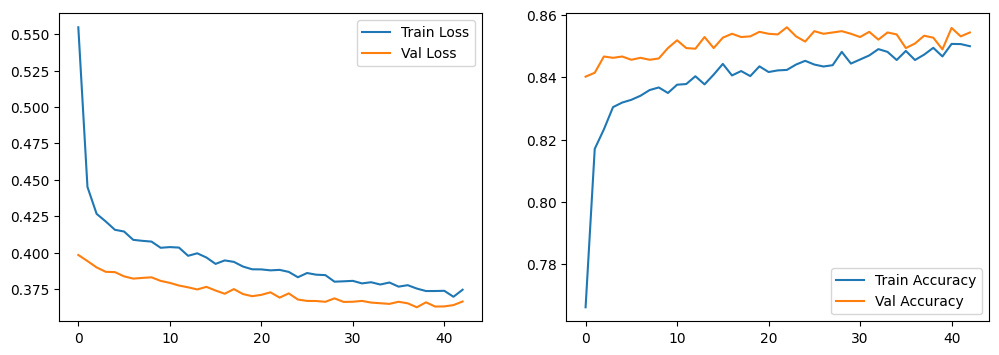

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Optimal Threshold: 0.5139
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

Dissatisfied       0.85      0.86      0.86      2999
   Satisfied       0.86      0.85      0.85      2999

    accuracy                           0.85      5998
   macro avg       0.85      0.85      0.85      5998
weighted avg       0.85      0.85      0.85      5998


Confusion Matrix:
[[2581  418]
 [ 452 2547]]


In [ ]:
"""
AIRLINE PASSENGER SATISFACTION PREDICTION MODEL

This script implements a neural network with hyperparameter tuning to predict 
airline passenger satisfaction. The workflow includes:
1. Data preparation and preprocessing
2. Automated hyperparameter tuning
3. Model training with optimal parameters
4. Comprehensive evaluation

Key Features:
- Uses Keras Tuner for automated hyperparameter optimization
- Implements early stopping to prevent overfitting
- Includes threshold optimization for binary classification
- Provides detailed performance metrics and visualizations
"""

# Import required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import keras_tuner as kt

# ====== DATA PREPARATION ======
"""
DATA PREPROCESSING PIPELINE:
1. Check dataset characteristics
2. Remove constant features
3. Standardize features
4. Create stratified train-test split
"""
print("\n=== Data Check ===")
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Class distribution (y):\n{pd.Series(y).value_counts()}")

# Remove features with zero variance (constant features)
non_constant_cols = X.std(axis=0) > 0
X = X.loc[:, non_constant_cols]

# Standardize features to mean=0, variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create stratified split (preserves class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# ====== HYPERPARAMETER TUNING ======
"""
HYPERPARAMETER OPTIMIZATION:
Uses Keras Tuner's Hyperband algorithm to search:
- Number of hidden layers (1-3)
- Units per layer (32-256)
- Dropout rates (0.1-0.5) 
- Learning rates (0.01, 0.001, 0.0001)
"""

def build_model(hp):
    """Build model with tunable hyperparameters"""
    model = Sequential()
    
    # Tune number of hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        # Tune units in each layer
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation='relu',
            input_shape=(X_train.shape[1],) if i == 0 else None
        ))
        model.add(BatchNormalization())
        # Tune dropout rate
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='tuning',
    project_name='airline_satisfaction'
)

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Execute hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal hyperparameters:
- Number of layers: {best_hps.get('num_layers')}
- Units in layers: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]}
- Dropout rates: {[best_hps.get(f'dropout_{i}') for i in range(best_hps.get('num_layers'))]}
- Learning rate: {best_hps.get('learning_rate')}
""")

# ====== MODEL TRAINING ======
"""
FINAL MODEL TRAINING:
- Builds model with optimal hyperparameters
- Trains with early stopping
- Uses 20% of training data for validation
"""

# Build model with best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train final model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# ====== MODEL EVALUATION ======
"""
COMPREHENSIVE EVALUATION:
1. Training history visualization
2. Optimal threshold calculation
3. Classification report
4. Confusion matrix
"""


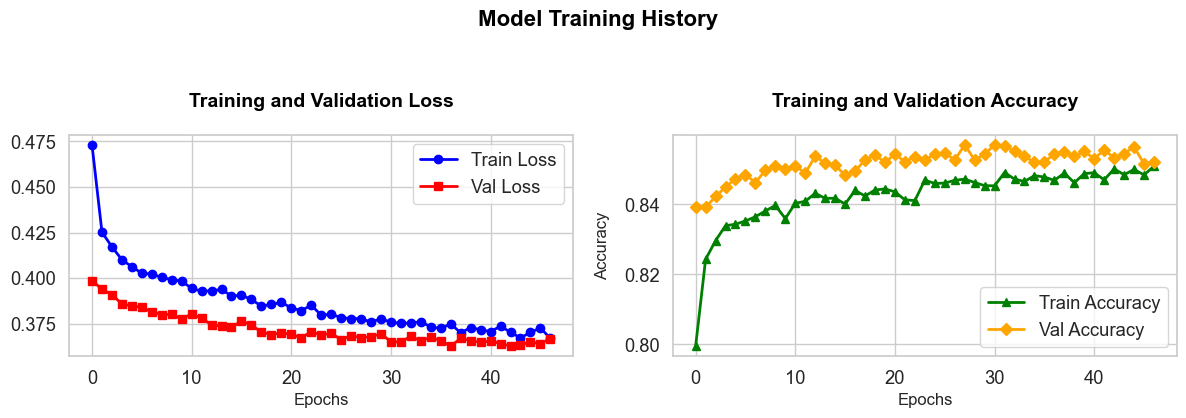

In [63]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2, marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', color='red', linewidth=2, marker='s')
plt.title('Training and Validation Loss', fontsize=14, pad=20, fontweight='bold', color='black')
plt.xlabel('Epochs', fontsize=12)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green', linewidth=2, marker='^')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange', linewidth=2, marker='D')
plt.xlabel('Epochs', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14, pad=20, fontweight='bold', color='black')
plt.ylabel('Accuracy', fontsize=12, labelpad=10)
plt.legend()

plt.suptitle('Model Training History', fontsize=16, fontweight='bold', y=1.05, color='black')
plt.tight_layout()
plt.show()


In [47]:
# Find optimal classification threshold
val_pred_prob = model.predict(X_train[:int(0.2 * len(X_train))])
fpr, tpr, thresholds = roc_curve(y_train[:int(0.2 * len(X_train))], val_pred_prob)
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print(f"\nOptimal Threshold: {optimal_threshold:.4f}")

# Evaluate on test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > optimal_threshold).astype('int32')

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Optimal Threshold: 0.5172
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [49]:
# Print performance metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Dissatisfied', 'Satisfied']))


Classification Report:
              precision    recall  f1-score   support

Dissatisfied       0.85      0.85      0.85      2999
   Satisfied       0.85      0.85      0.85      2999

    accuracy                           0.85      5998
   macro avg       0.85      0.85      0.85      5998
weighted avg       0.85      0.85      0.85      5998



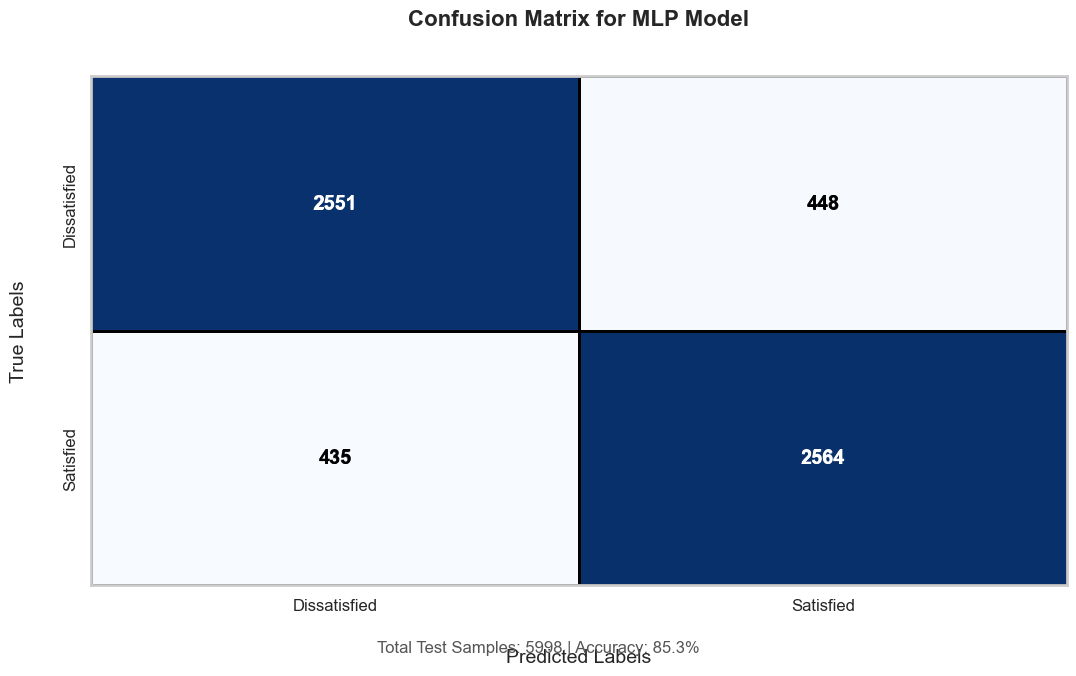

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create visualization
plt.figure(figsize=(11, 7))
sns.set(font_scale=1.2, style='whitegrid')

# Create heatmap
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar=False, linewidths=1, linecolor='black',
                annot_kws={'size': 14, 'weight': 'bold'})

# Add labels and title
ax.set_xlabel('\nPredicted Labels', fontsize=14, labelpad=10)
ax.set_ylabel('True Labels\n', fontsize=14, labelpad=10)
ax.set_title('Confusion Matrix for MLP Model\n', fontsize=16, fontweight='bold', pad=20)

# Set tick labels
class_names = ['Dissatisfied', 'Satisfied']
ax.xaxis.set_ticklabels(class_names, fontsize=12)
ax.yaxis.set_ticklabels(class_names, fontsize=12)

# Add value annotations with contrast colors
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black",
                fontweight='bold')

# Add border
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)

# Calculate and display metrics
plt.figtext(0.5, 0.05, 
           f"Total Test Samples: {len(y_test)} | Accuracy: {np.trace(cm)/np.sum(cm):.1%}",
           ha="center", fontsize=12, color='#555555')

plt.tight_layout()
plt.show()

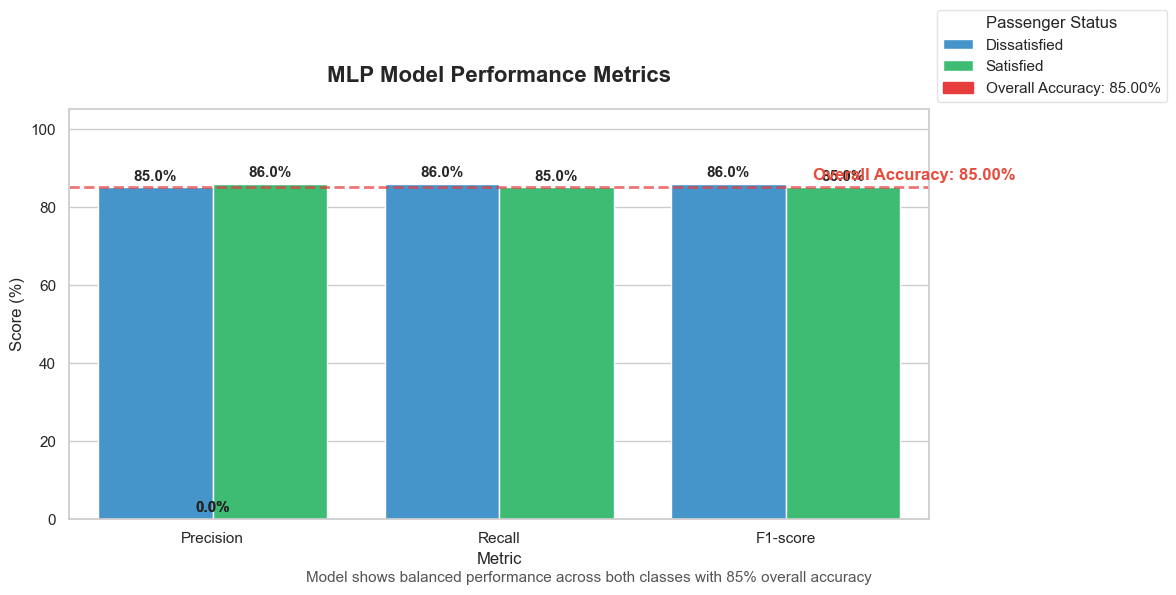

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Updated metrics with new scores from classification report
metrics = {
    'Class': ['Dissatisfied', 'Dissatisfied', 'Dissatisfied', 'Satisfied', 'Satisfied', 'Satisfied'],
    'Metric': ['Precision', 'Recall', 'F1-score'] * 2,
    'Score': [0.85, 0.86, 0.86, 0.86, 0.85, 0.85]  # Updated scores
}

# Overall accuracy from new report
accuracy = 0.85  # Updated accuracy
accuracy_percent = accuracy * 100
accuracy_label = f'Overall Accuracy: {accuracy_percent:.2f}%'

# Create DataFrame
class_metrics = pd.DataFrame(metrics)
class_metrics['Score'] = class_metrics['Score'] * 100  # Convert to percentages

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")  # Cleaner background

ax = sns.barplot(data=class_metrics, x='Metric', y='Score', hue='Class', 
                 palette=['#3498db', '#2ecc71'], saturation=0.8)  # Blue and green colors

# Add value labels on bars, skipping 0.0% label for the first bar (index 0)
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    # Skip label if height is 0.0%
    if not (i == 0 and abs(height) < 1e-5):
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')

# Add accuracy line
plt.axhline(accuracy_percent, color="#e73c3c", linestyle='--', linewidth=2, alpha=0.7)
plt.text(2.8, accuracy_percent + 2, accuracy_label, 
         color='#e74c3c', fontsize=12, fontweight='bold', ha='right')

# Enhancements
plt.ylim(0, 105)
plt.title('MLP Model Performance Metrics', 
          fontsize=16, pad=20, fontweight='bold')
plt.ylabel('Score (%)', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Improve legend — add overall accuracy as an extra legend entry
handles, labels = ax.get_legend_handles_labels()
from matplotlib.patches import Patch
accuracy_patch = Patch(color='#e73c3c', label=accuracy_label)
handles.append(accuracy_patch)
labels.append(accuracy_label)

legend = plt.legend(handles=handles, labels=labels,
                   title='Passenger Status', 
                   loc='lower left', 
                   bbox_to_anchor=(1, 1),
                   frameon=True,
                   title_fontsize=12,
                   fontsize=11)
legend.get_frame().set_edgecolor('#dddddd')

# Add caption
plt.figtext(0.5, 0.01, 
           "Model shows balanced performance across both classes with 85% overall accuracy",
           ha="center", fontsize=11, color='#555555')

plt.tight_layout()
plt.show()


#### Visualize Training and Testing Accuracy

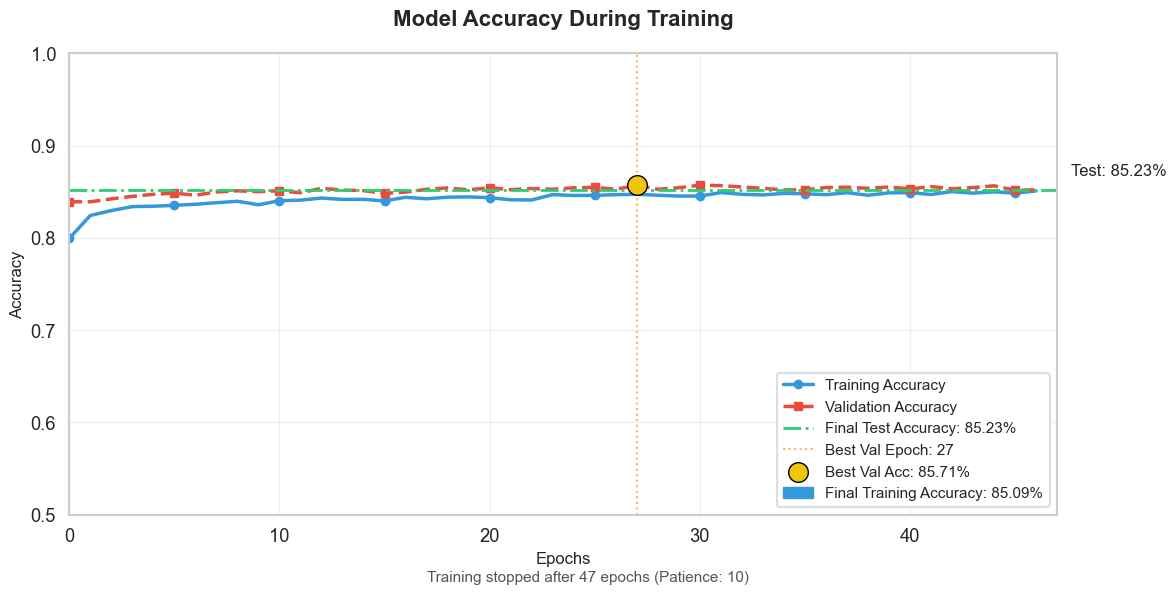

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# ====== TRAINING/TESTING ACCURACY VISUALIZATION ======
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], 
         label='Training Accuracy',
         color='#3498db', 
         linewidth=2.5,
         marker='o',
         markersize=6,
         markevery=5)

plt.plot(history.history['val_accuracy'], 
         label='Validation Accuracy',
         color='#e74c3c',
         linewidth=2.5,
         linestyle='--',
         marker='s',
         markersize=6,
         markevery=5)

# Add test accuracy point (if available)
try:
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    plt.axhline(y=test_acc, 
                color='#2ecc71', 
                linestyle='-.',
                linewidth=2,
                label=f'Final Test Accuracy: {test_acc:.2%}')
    
    # Annotate test accuracy
    plt.annotate(f'Test: {test_acc:.2%}',
                 xy=(len(history.history['accuracy']), test_acc),
                 xytext=(10, 10),
                 textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
                 fontsize=12)
except:
    test_acc = None  # For safety if evaluate fails

# Highlight best validation accuracy
best_val_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = max(history.history['val_accuracy'])
plt.axvline(x=best_val_epoch, 
            color='#f39c12', 
            linestyle=':',
            alpha=0.7,
            label=f'Best Val Epoch: {best_val_epoch}')

# Add markers for important points
plt.scatter(best_val_epoch, best_val_acc,
            color='#f1c40f',
            s=200,
            edgecolor='black',
            zorder=10,
            label=f'Best Val Acc: {best_val_acc:.2%}')

# Add final training accuracy to legend label
final_train_acc = history.history['accuracy'][-1]
train_acc_label = f'Final Training Accuracy: {final_train_acc:.2%}'

# Formatting
plt.title('Model Accuracy During Training', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.5, 1.0)  # Focus on relevant accuracy range
plt.xlim(0, len(history.history['accuracy']))

# Custom legend: add final training accuracy manually
handles, labels = plt.gca().get_legend_handles_labels()
from matplotlib.patches import Patch
train_acc_patch = Patch(color='#3498db', label=train_acc_label)
handles.append(train_acc_patch)
labels.append(train_acc_label)

legend = plt.legend(handles=handles, labels=labels,
                   loc='lower right', 
                   frameon=True, 
                   facecolor='white',
                   framealpha=1,
                   edgecolor='#dddddd',
                   fontsize=11)
legend.get_frame().set_linewidth(1.5)

# Add grid and borders
plt.grid(True, alpha=0.3)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

# Add caption
plt.figtext(0.5, 0.01, 
           f"Training stopped after {len(history.history['accuracy'])} epochs (Patience: 10)",
           ha="center", 
           fontsize=11, 
           color='#555555')

plt.tight_layout()
plt.show()


#### 2. TabNet

In [66]:
#Step 1: Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
# Step 2: Load and Prepare the Data
# Load data: Read the CSV file into a Pandas DataFrame
data = pd.read_csv("balanced_dataset.csv")

# Drop unwanted columns
data = data.drop(columns=["Unnamed: 21", "Unnamed: 22"], errors='ignore')

# Features and target:
# X contains all the columns except the target variable "Satisfaction_Satisfied"
# y contains the target variable "Satisfaction_Satisfied"
X = data.drop("Satisfaction_Satisfied", axis=1).values  # Features (all columns except target)
y = data["Satisfaction_Satisfied"].values  # Target variable (customer satisfaction)

# Train-test split:
# Split the dataset into training and testing sets (80% training, 20% testing)
# Stratified split ensures that the proportion of each class in y is maintained in both the training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [71]:
data.isnull().sum()  # Check for missing values

Age                                0
Arrival Service                    0
Booking Services                   0
Immediate Transfer                 0
Lounge Service                     0
Check-in Service                   0
Boarding Service                   0
Layover Service                    0
Onboard Services                   0
Baggage Service                    0
Immigration Security               0
Call Center Service                0
Departure Delay                    0
Arrival Delay                      0
Total Delay                        0
Gender_Male                        0
Customer Type_disloyal Customer    0
Type of Travel_Personal            0
Class_Eco                          0
Class_Leisure                      0
Satisfaction_Satisfied             0
dtype: int64

In [72]:
# Import necessary libraries
from pytorch_tabnet.tab_model import TabNetClassifier
import numpy as np
import pandas as pd

# Safely convert to numpy arrays if still DataFrame/Series
# This function ensures that the input data (X or y) is converted to numpy arrays (if they are still pandas DataFrame/Series).
# It also allows specifying the dtype for the conversion, for example, np.float32 or np.int64.
def ensure_numpy(X, dtype=None):
    if isinstance(X, (pd.DataFrame, pd.Series)):
        return X.to_numpy(dtype=dtype)  # Convert DataFrame/Series to numpy array
    return X.astype(dtype) if dtype else X  # Return numpy array with specified dtype if needed

# Convert training and testing data to numpy arrays with appropriate data types
X_train_np = ensure_numpy(X_train, np.float32)  # Features for training (convert to float32)
X_test_np = ensure_numpy(X_test, np.float32)    # Features for testing (convert to float32)
y_train_np = ensure_numpy(y_train, np.int64).flatten()  # Target for training (convert to int64 and flatten)
y_test_np = ensure_numpy(y_test, np.int64).flatten()    # Target for testing (convert to int64 and flatten)

# Train TabNet model
# Instantiate the TabNetClassifier model, specifying 'auto' for device_name to use the available device (CPU/GPU).
tabnet_model = TabNetClassifier(device_name='auto')

# Fit the model using the training data (X_train_np, y_train_np) and evaluate on the test data (X_test_np, y_test_np).
tabnet_model.fit(
    X_train_np, y_train_np,  # Training data and labels
    eval_set=[(X_test_np, y_test_np)],  # Evaluation data and labels
    eval_name=["val"],  # Evaluation set name
    eval_metric=["accuracy"],  # Metric to monitor for evaluation (accuracy)
    max_epochs=100,  # Maximum number of epochs for training
    patience=10,  # Early stopping patience (number of epochs with no improvement)
    batch_size=1024,  # Batch size for training
    virtual_batch_size=128,  # Virtual batch size for training (for gradient accumulation)
    num_workers=0,  # Number of workers for data loading (use 0 for no parallelism)
    drop_last=False  # Don't drop the last batch if it's smaller than batch_size
)

epoch 0  | loss: 0.56296 | val_accuracy: 0.79326 |  0:00:01s
epoch 1  | loss: 0.44684 | val_accuracy: 0.81644 |  0:00:02s
epoch 2  | loss: 0.43508 | val_accuracy: 0.81694 |  0:00:03s
epoch 3  | loss: 0.42388 | val_accuracy: 0.82644 |  0:00:05s
epoch 4  | loss: 0.41489 | val_accuracy: 0.83461 |  0:00:06s
epoch 5  | loss: 0.40764 | val_accuracy: 0.83778 |  0:00:08s
epoch 6  | loss: 0.4029  | val_accuracy: 0.83895 |  0:00:09s
epoch 7  | loss: 0.40075 | val_accuracy: 0.83561 |  0:00:10s
epoch 8  | loss: 0.4009  | val_accuracy: 0.84128 |  0:00:12s
epoch 9  | loss: 0.39847 | val_accuracy: 0.84395 |  0:00:13s
epoch 10 | loss: 0.39885 | val_accuracy: 0.84578 |  0:00:14s
epoch 11 | loss: 0.39587 | val_accuracy: 0.84628 |  0:00:15s
epoch 12 | loss: 0.39539 | val_accuracy: 0.84695 |  0:00:17s
epoch 13 | loss: 0.39544 | val_accuracy: 0.84361 |  0:00:18s
epoch 14 | loss: 0.39248 | val_accuracy: 0.84011 |  0:00:19s
epoch 15 | loss: 0.38969 | val_accuracy: 0.84378 |  0:00:20s
epoch 16 | loss: 0.38865


Classification Report:
               precision    recall  f1-score   support

Dissatisfied       0.85      0.84      0.85      2999
   Satisfied       0.84      0.86      0.85      2999

    accuracy                           0.85      5998
   macro avg       0.85      0.85      0.85      5998
weighted avg       0.85      0.85      0.85      5998



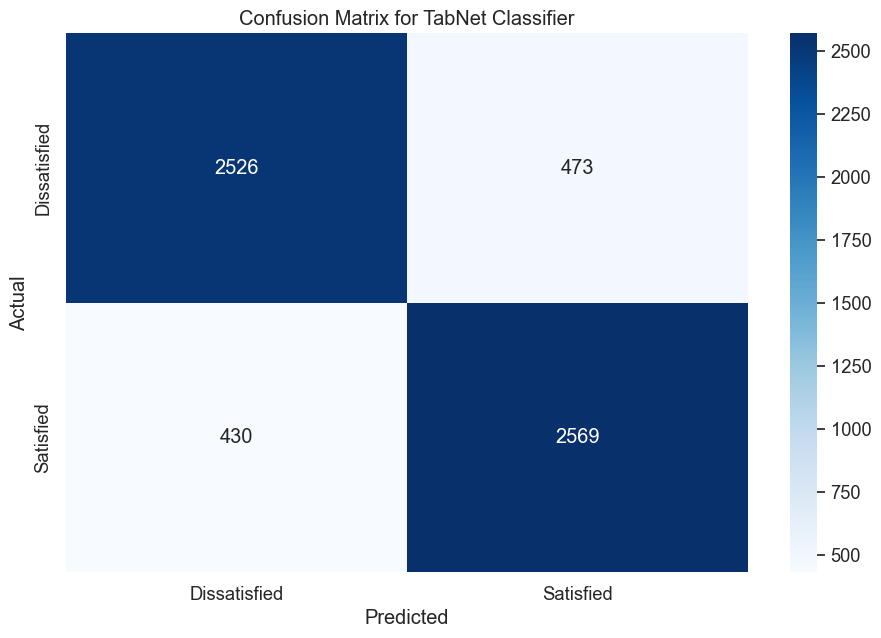

In [73]:
# Import necessary libraries for evaluation
from sklearn.metrics import classification_report, confusion_matrix  # For generating classification report and confusion matrix
import seaborn as sns  # For creating heatmaps
import matplotlib.pyplot as plt  # For plotting the confusion matrix
import numpy as np

# Ensure X_test is a NumPy array of correct dtype
X_test_np = X_test.to_numpy(dtype=np.float32) if hasattr(X_test, "to_numpy") else X_test.astype(np.float32)

# Predict using the trained TabNet model
y_pred = tabnet_model.predict(X_test_np)

# If predictions are probabilities, convert to class labels (True/False)
if y_pred.ndim > 1 and y_pred.shape[1] > 1:
    y_pred = np.argmax(y_pred, axis=1)  # For multiclass
else:
    y_pred = (y_pred > 0.5).astype("int32").flatten()  # For binary classification

# Convert boolean/int labels to strings
y_test_named = np.where(y_test, "Satisfied", "Dissatisfied")
y_pred_named = np.where(y_pred, "Satisfied", "Dissatisfied")

# Classification Report
print("\nClassification Report:\n", classification_report(y_test_named, y_pred_named))

# Confusion Matrix
cm = confusion_matrix(y_test_named, y_pred_named, labels=["Dissatisfied", "Satisfied"])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(11, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Dissatisfied", "Satisfied"],
            yticklabels=["Dissatisfied", "Satisfied"])
plt.title("Confusion Matrix for TabNet Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Visualizing Classification Report

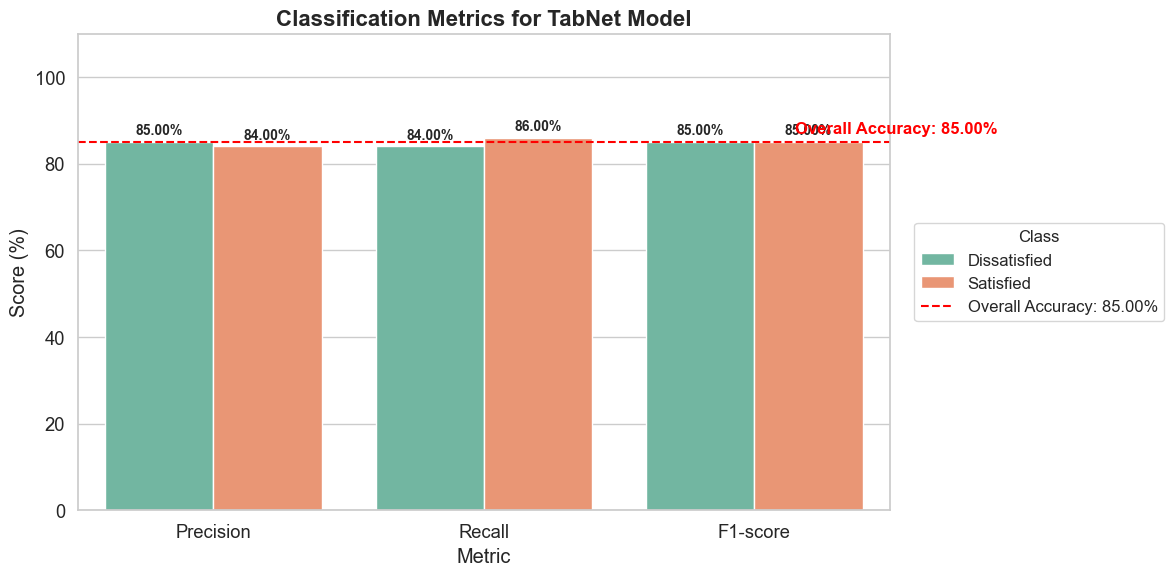

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 8: Plot Classification Metrics

# Updated classification report data
metrics = {
    'Class': ['Dissatisfied', 'Dissatisfied', 'Dissatisfied',
              'Satisfied', 'Satisfied', 'Satisfied'],
    'Metric': ['Precision', 'Recall', 'F1-score'] * 2,
    'Score': [0.85, 0.84, 0.85, 0.84, 0.86, 0.85]  # Updated from classification report
}

# Overall accuracy
accuracy = 0.85
accuracy_percent = accuracy * 100
accuracy_label = f'Overall Accuracy: {accuracy_percent:.2f}%'

# Create DataFrame
class_metrics = pd.DataFrame(metrics)
class_metrics['Score'] = class_metrics['Score'] * 100  # Convert to percentage

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=class_metrics, x='Metric', y='Score', hue='Class', palette='Set2')

# Add score labels
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        ax.text(x, height + 1, f'{height:.2f}%', ha='center', va='bottom', fontsize=10, weight='bold')

# Add horizontal accuracy line
plt.axhline(accuracy_percent, color='red', linestyle='--', linewidth=1.5, label=accuracy_label)
plt.text(
    x=2.9, y=accuracy_percent + 2,
    s=accuracy_label,
    color='red',
    fontsize=12,
    ha='right',
    fontweight='bold'
)

# Final touches
plt.ylim(0, 110)
plt.title('Classification Metrics for TabNet Model', fontsize=16, fontweight='bold')
plt.ylabel('Score (%)')
plt.xlabel('Metric')
plt.legend(title='Class', loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12, title_fontsize=12, frameon=True)
plt.tight_layout()
plt.show()


#### Step 5:Visualize Training History

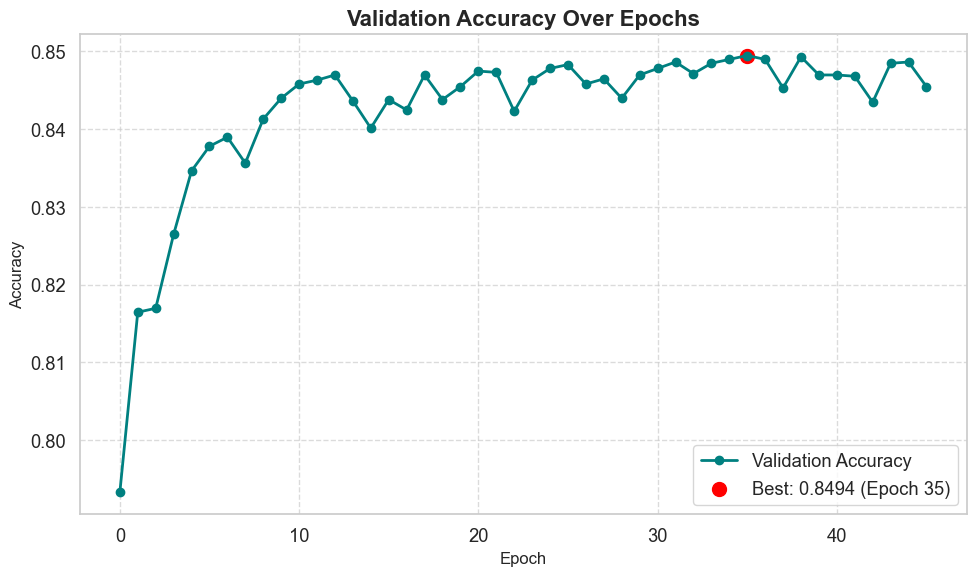

Successfully saved model at tabnet_model.zip


'tabnet_model.zip'

In [75]:
import matplotlib.pyplot as plt

# Extract accuracy history
val_accuracy = tabnet_model.history["val_accuracy"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(val_accuracy, marker='o', linestyle='-', color='teal', linewidth=2, label='Validation Accuracy')

# Highlight best accuracy
best_epoch = np.argmax(val_accuracy)
best_acc = val_accuracy[best_epoch]
plt.scatter(best_epoch, best_acc, color='red', s=100, label=f'Best: {best_acc:.4f} (Epoch {best_epoch})')

# Add labels, title and legend
plt.title("Validation Accuracy Over Epochs", fontsize=16, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()
# Save the trained TabNet model
tabnet_model.save_model("tabnet_model")  # Save the model to a file

#### Training Loss and Validation Accuracy Over Epochs

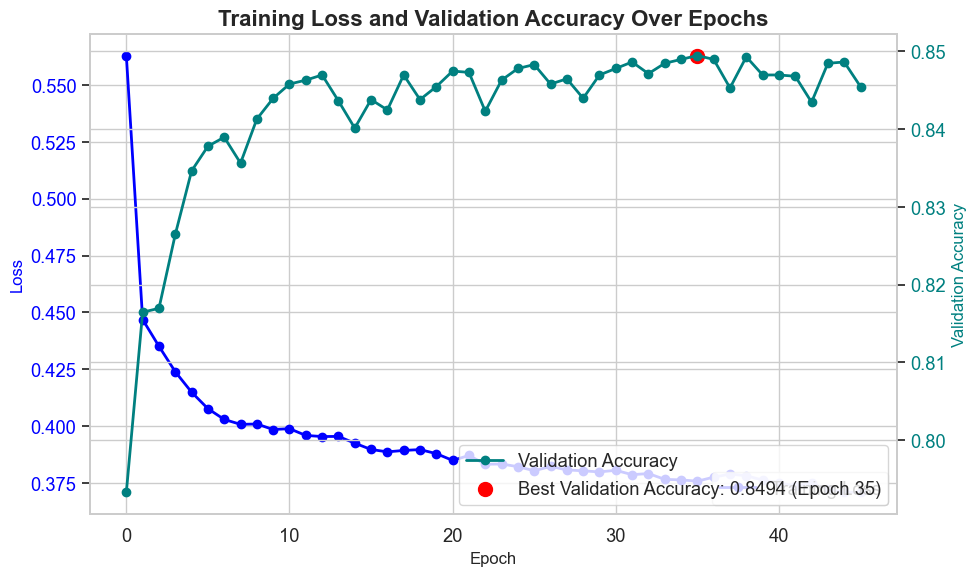

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Extract loss and validation accuracy history
train_loss = tabnet_model.history["loss"]  # Training loss
val_accuracy = tabnet_model.history["val_accuracy"]  # Validation accuracy (Testing accuracy)

# Step 2: Create the plot for loss and validation accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training loss (using the primary axis)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12, color='blue')
ax1.plot(train_loss, marker='o', linestyle='-', color='blue', linewidth=2, label='Training Loss')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second axis to plot validation accuracy
ax2 = ax1.twinx()  # Create a second y-axis
ax2.set_ylabel("Validation Accuracy", fontsize=12, color='teal')
ax2.plot(val_accuracy, marker='o', linestyle='-', color='teal', linewidth=2, label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor='teal')

# Highlight best validation accuracy
best_epoch = np.argmax(val_accuracy)
best_acc = val_accuracy[best_epoch]
ax2.scatter(best_epoch, best_acc, color='red', s=100, label=f'Best Validation Accuracy: {best_acc:.4f} (Epoch {best_epoch})')

# Step 3: Add title and legend
plt.title("Training Loss and Validation Accuracy Over Epochs", fontsize=16, fontweight='bold')
fig.tight_layout()  # To ensure the layout is adjusted

# Show both legends for loss and accuracy
ax1.legend(loc="lower right")
ax2.legend(loc="lower right")

# Step 4: Show the plot
plt.show()


#### Hyper-parameter tuning For TabNet

In [42]:
import optuna
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Ensure data is numpy
def ensure_numpy(X, dtype=None):
    if isinstance(X, (pd.DataFrame, pd.Series)):
        return X.to_numpy(dtype=dtype)
    return X.astype(dtype) if dtype else X

# Convert data
X_train_np = ensure_numpy(X_train, np.float32)
X_test_np = ensure_numpy(X_test, np.float32)
y_train_np = ensure_numpy(y_train, np.int64).flatten()
y_test_np = ensure_numpy(y_test, np.int64).flatten()

# Objective function for Optuna
def objective(trial):
    params = {
        "n_d": trial.suggest_int("n_d", 8, 64),
        "n_a": trial.suggest_int("n_a", 8, 64),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-6, 1e-2, log=True),
        "optimizer_params": dict(lr=trial.suggest_float("lr", 1e-4, 0.1, log=True)),
        "mask_type": trial.suggest_categorical("mask_type", ["entmax", "sparsemax"]),
        "scheduler_params": {"step_size": 10, "gamma": 0.9},
        "scheduler_fn": torch.optim.lr_scheduler.StepLR,
        "verbose": 0,
        "seed": 42,
        "device_name": "auto"
    }

    model = TabNetClassifier(**params)

    model.fit(
        X_train_np, y_train_np,
        eval_set=[(X_test_np, y_test_np)],
        eval_name=["val"],
        eval_metric=["accuracy"],
        max_epochs=100,
        patience=10,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

    preds = model.predict(X_test_np)
    acc = accuracy_score(y_test_np, preds)
    return acc

# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=1800)  # 30 trials or 30 minutes

# Best parameters and accuracy
print("Best trial:")
trial = study.best_trial
print("  Accuracy: {:.4f}".format(trial.value))
print("  Best hyperparameters:", trial.params)


[I 2025-05-09 12:22:13,384] A new study created in memory with name: no-name-40dd0d8d-8991-4e04-be4b-fa0c9b6fb95a



Early stopping occurred at epoch 66 with best_epoch = 56 and best_val_accuracy = 0.83625


[I 2025-05-09 12:24:32,669] Trial 0 finished with value: 0.83625 and parameters: {'n_d': 22, 'n_a': 15, 'n_steps': 9, 'gamma': 1.1645962889667196, 'lambda_sparse': 4.960407975503339e-05, 'lr': 0.01946599991393541, 'mask_type': 'entmax'}. Best is trial 0 with value: 0.83625.



Early stopping occurred at epoch 92 with best_epoch = 82 and best_val_accuracy = 0.79425


[I 2025-05-09 12:26:58,590] Trial 1 finished with value: 0.79425 and parameters: {'n_d': 33, 'n_a': 53, 'n_steps': 5, 'gamma': 1.4535207087510917, 'lambda_sparse': 0.0041606006637799845, 'lr': 0.00024826141646115045, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.83625.



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_accuracy = 0.82425


[I 2025-05-09 12:27:59,110] Trial 2 finished with value: 0.82425 and parameters: {'n_d': 18, 'n_a': 61, 'n_steps': 8, 'gamma': 1.0961817152584747, 'lambda_sparse': 0.0004197414187590395, 'lr': 0.0034353110732287537, 'mask_type': 'entmax'}. Best is trial 0 with value: 0.83625.



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_accuracy = 0.77975


[I 2025-05-09 12:29:59,783] Trial 3 finished with value: 0.77975 and parameters: {'n_d': 49, 'n_a': 50, 'n_steps': 8, 'gamma': 1.3166199898462416, 'lambda_sparse': 0.004049362550799091, 'lr': 0.00018050770685778316, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.83625.



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_accuracy = 0.8365


[I 2025-05-09 12:31:30,336] Trial 4 finished with value: 0.8365 and parameters: {'n_d': 27, 'n_a': 19, 'n_steps': 10, 'gamma': 1.819546571564768, 'lambda_sparse': 0.007373575806094416, 'lr': 0.09984964123260844, 'mask_type': 'entmax'}. Best is trial 4 with value: 0.8365.



Early stopping occurred at epoch 61 with best_epoch = 51 and best_val_accuracy = 0.7945


[I 2025-05-09 12:33:21,133] Trial 5 finished with value: 0.7945 and parameters: {'n_d': 11, 'n_a': 37, 'n_steps': 8, 'gamma': 1.2405301638872177, 'lambda_sparse': 7.134052881021228e-06, 'lr': 0.00028995770315251704, 'mask_type': 'entmax'}. Best is trial 4 with value: 0.8365.



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_accuracy = 0.78475


[I 2025-05-09 12:34:39,104] Trial 6 finished with value: 0.78475 and parameters: {'n_d': 35, 'n_a': 19, 'n_steps': 9, 'gamma': 1.3991372105096178, 'lambda_sparse': 4.839209817132445e-06, 'lr': 0.0007618173802528259, 'mask_type': 'sparsemax'}. Best is trial 4 with value: 0.8365.



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_accuracy = 0.8305


[I 2025-05-09 12:35:20,515] Trial 7 finished with value: 0.8305 and parameters: {'n_d': 8, 'n_a': 45, 'n_steps': 5, 'gamma': 1.2955651021777768, 'lambda_sparse': 1.8384118565628105e-06, 'lr': 0.01466845058967145, 'mask_type': 'sparsemax'}. Best is trial 4 with value: 0.8365.



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_accuracy = 0.81075


[I 2025-05-09 12:37:27,252] Trial 8 finished with value: 0.81075 and parameters: {'n_d': 43, 'n_a': 44, 'n_steps': 10, 'gamma': 1.4926922465950525, 'lambda_sparse': 0.00030330554726685734, 'lr': 0.006823854885341367, 'mask_type': 'entmax'}. Best is trial 4 with value: 0.8365.



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_accuracy = 0.825


[I 2025-05-09 12:39:02,490] Trial 9 finished with value: 0.825 and parameters: {'n_d': 38, 'n_a': 35, 'n_steps': 7, 'gamma': 1.6645443733887244, 'lambda_sparse': 0.002236455306651245, 'lr': 0.004964822584174921, 'mask_type': 'entmax'}. Best is trial 4 with value: 0.8365.



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_accuracy = 0.84075


[I 2025-05-09 12:39:46,490] Trial 10 finished with value: 0.84075 and parameters: {'n_d': 59, 'n_a': 26, 'n_steps': 3, 'gamma': 1.9948410713859668, 'lambda_sparse': 3.815861266777448e-05, 'lr': 0.08163311388002503, 'mask_type': 'entmax'}. Best is trial 10 with value: 0.84075.



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_accuracy = 0.83775


[I 2025-05-09 12:40:26,619] Trial 11 finished with value: 0.83775 and parameters: {'n_d': 62, 'n_a': 23, 'n_steps': 3, 'gamma': 1.992184887753239, 'lambda_sparse': 3.123657401921638e-05, 'lr': 0.09982180427322067, 'mask_type': 'entmax'}. Best is trial 10 with value: 0.84075.



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_accuracy = 0.8385


[I 2025-05-09 12:41:02,077] Trial 12 finished with value: 0.8385 and parameters: {'n_d': 64, 'n_a': 28, 'n_steps': 3, 'gamma': 1.9817904246789702, 'lambda_sparse': 2.767143879895523e-05, 'lr': 0.09384681100690163, 'mask_type': 'entmax'}. Best is trial 10 with value: 0.84075.



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_accuracy = 0.8365


[I 2025-05-09 12:41:26,005] Trial 13 finished with value: 0.8365 and parameters: {'n_d': 63, 'n_a': 29, 'n_steps': 3, 'gamma': 1.9595752743532802, 'lambda_sparse': 1.4635217734295391e-05, 'lr': 0.032108999346856945, 'mask_type': 'entmax'}. Best is trial 10 with value: 0.84075.



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_accuracy = 0.83825


[I 2025-05-09 12:42:09,872] Trial 14 finished with value: 0.83825 and parameters: {'n_d': 53, 'n_a': 28, 'n_steps': 4, 'gamma': 1.6959407099434765, 'lambda_sparse': 0.0001594879142658982, 'lr': 0.04613902982197664, 'mask_type': 'entmax'}. Best is trial 10 with value: 0.84075.



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_accuracy = 0.809


[I 2025-05-09 13:27:58,436] Trial 15 finished with value: 0.809 and parameters: {'n_d': 55, 'n_a': 10, 'n_steps': 5, 'gamma': 1.8252669495870673, 'lambda_sparse': 6.595981751232756e-05, 'lr': 0.0014708318535848156, 'mask_type': 'entmax'}. Best is trial 10 with value: 0.84075.


Best trial:
  Accuracy: 0.8407
  Best hyperparameters: {'n_d': 59, 'n_a': 26, 'n_steps': 3, 'gamma': 1.9948410713859668, 'lambda_sparse': 3.815861266777448e-05, 'lr': 0.08163311388002503, 'mask_type': 'entmax'}


#### Hyper-Parameter Tuning + TabNet

In [78]:
from pytorch_tabnet.tab_model import TabNetClassifier
import numpy as np
import pandas as pd

# Safely convert to numpy arrays if still DataFrame/Series
def ensure_numpy(X, dtype=None):
    if isinstance(X, (pd.DataFrame, pd.Series)):
        return X.to_numpy(dtype=dtype)  # Convert DataFrame/Series to numpy array
    return X.astype(dtype) if dtype else X  # Return numpy array with specified dtype if needed

# Convert training and testing data to numpy arrays with appropriate data types
X_train_np = ensure_numpy(X_train, np.float32)  # Features for training (convert to float32)
X_test_np = ensure_numpy(X_test, np.float32)    # Features for testing (convert to float32)
y_train_np = ensure_numpy(y_train, np.int64).flatten()  # Target for training (convert to int64 and flatten)
y_test_np = ensure_numpy(y_test, np.int64).flatten()    # Target for testing (convert to int64 and flatten)

# Instantiate the TabNetClassifier model with the best hyperparameters
tabnet_model = TabNetClassifier(
    n_d=59,  # Dimension of decision layer
    n_a=26,  # Dimension of attention layer
    n_steps=3,  # Number of steps
    gamma=1.9948410713859668,  # Feature reusage coefficient
    lambda_sparse=3.815861266777448e-05,  # Sparse regularization strength
    optimizer_params=dict(lr=0.08163311388002503),  # Learning rate
    mask_type='entmax',  # Mask type ('entmax')
    device_name='auto'  # Use auto device selection (CPU/GPU)
)

# Fit the model using the training data (X_train_np, y_train_np) and evaluate on the test data (X_test_np, y_test_np).
tabnet_model.fit(
    X_train_np, y_train_np,  # Training data and labels
    eval_set=[(X_test_np, y_test_np)],  # Evaluation data and labels
    eval_name=["val"],  # Evaluation set name
    eval_metric=["accuracy"],  # Metric to monitor for evaluation (accuracy)
    max_epochs=100,  # Maximum number of epochs for training
    patience=10,  # Early stopping patience (number of epochs with no improvement)
    batch_size=1024,  # Batch size for training
    virtual_batch_size=128,  # Virtual batch size for training (for gradient accumulation)
    num_workers=0,  # Number of workers for data loading (use 0 for no parallelism)
    drop_last=False  # Don't drop the last batch if it's smaller than batch_size
)

epoch 0  | loss: 0.87143 | val_accuracy: 0.80577 |  0:00:01s
epoch 1  | loss: 0.4336  | val_accuracy: 0.83044 |  0:00:03s
epoch 2  | loss: 0.42673 | val_accuracy: 0.83178 |  0:00:05s
epoch 3  | loss: 0.42312 | val_accuracy: 0.83378 |  0:00:07s
epoch 4  | loss: 0.42047 | val_accuracy: 0.83528 |  0:00:09s
epoch 5  | loss: 0.41505 | val_accuracy: 0.83561 |  0:00:11s
epoch 6  | loss: 0.40879 | val_accuracy: 0.84095 |  0:00:12s
epoch 7  | loss: 0.40384 | val_accuracy: 0.83995 |  0:00:14s
epoch 8  | loss: 0.40056 | val_accuracy: 0.84045 |  0:00:16s
epoch 9  | loss: 0.39993 | val_accuracy: 0.84028 |  0:00:18s
epoch 10 | loss: 0.39424 | val_accuracy: 0.84495 |  0:00:20s
epoch 11 | loss: 0.39712 | val_accuracy: 0.84712 |  0:00:21s
epoch 12 | loss: 0.39767 | val_accuracy: 0.83811 |  0:00:23s
epoch 13 | loss: 0.39331 | val_accuracy: 0.84145 |  0:00:25s
epoch 14 | loss: 0.39106 | val_accuracy: 0.84762 |  0:00:27s
epoch 15 | loss: 0.39012 | val_accuracy: 0.84211 |  0:00:29s
epoch 16 | loss: 0.39076

#### Classification Report


Classification Report:
               precision    recall  f1-score   support

Dissatisfied       0.86      0.83      0.85      2999
   Satisfied       0.84      0.87      0.85      2999

    accuracy                           0.85      5998
   macro avg       0.85      0.85      0.85      5998
weighted avg       0.85      0.85      0.85      5998



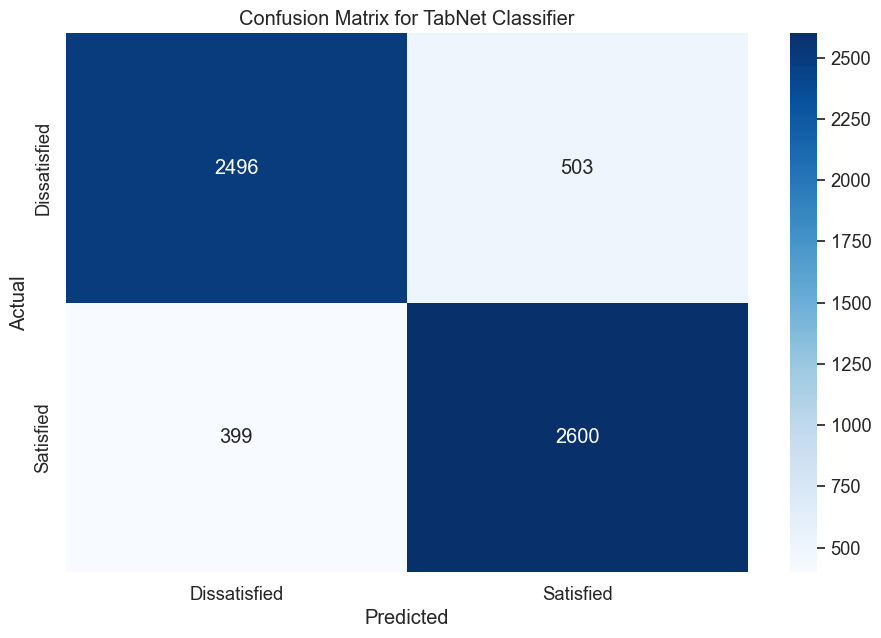

In [79]:
# Import necessary libraries for evaluation
from sklearn.metrics import classification_report, confusion_matrix  # For generating classification report and confusion matrix
import seaborn as sns  # For creating heatmaps
import matplotlib.pyplot as plt  # For plotting the confusion matrix
import numpy as np

# Ensure X_test is a NumPy array of correct dtype
X_test_np = X_test.to_numpy(dtype=np.float32) if hasattr(X_test, "to_numpy") else X_test.astype(np.float32)

# Predict using the trained TabNet model
y_pred = tabnet_model.predict(X_test_np)

# If predictions are probabilities, convert to class labels (True/False)
if y_pred.ndim > 1 and y_pred.shape[1] > 1:
    y_pred = np.argmax(y_pred, axis=1)  # For multiclass
else:
    y_pred = (y_pred > 0.5).astype("int32").flatten()  # For binary classification

# Convert boolean/int labels to strings
y_test_named = np.where(y_test, "Satisfied", "Dissatisfied")
y_pred_named = np.where(y_pred, "Satisfied", "Dissatisfied")

# Classification Report
print("\nClassification Report:\n", classification_report(y_test_named, y_pred_named))

# Confusion Matrix
cm = confusion_matrix(y_test_named, y_pred_named, labels=["Dissatisfied", "Satisfied"])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(11, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Dissatisfied", "Satisfied"],
            yticklabels=["Dissatisfied", "Satisfied"])
plt.title("Confusion Matrix for TabNet Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Visualizing Classification Report

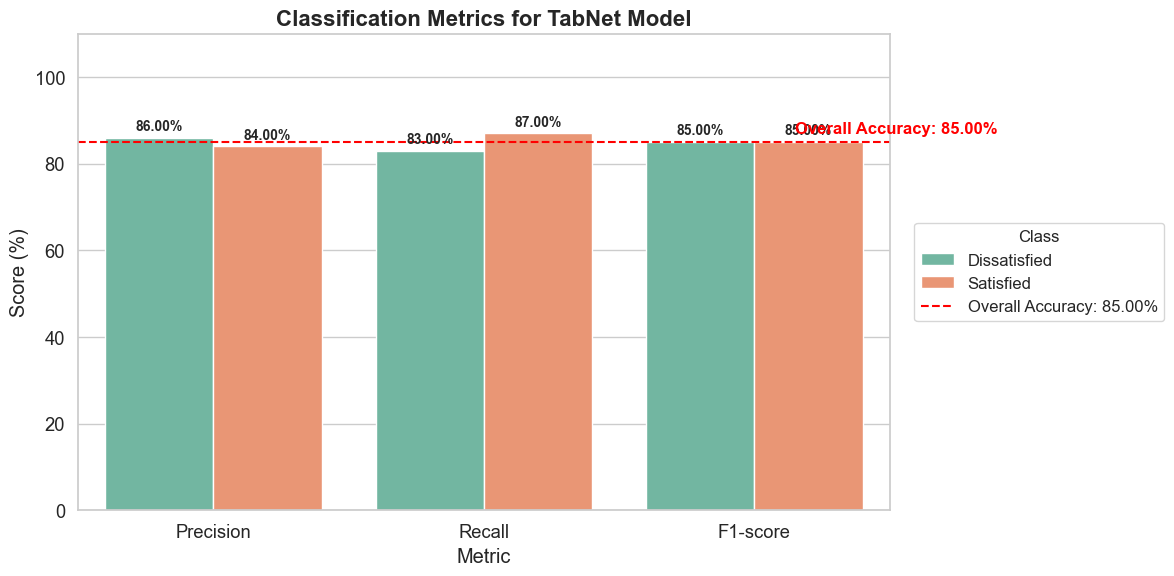

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 8: Plot Classification Metrics

# Updated classification report data (Dissatisfied and Satisfied classes)
metrics = {
    'Class': ['Dissatisfied', 'Dissatisfied', 'Dissatisfied',
              'Satisfied', 'Satisfied', 'Satisfied'],
    'Metric': ['Precision', 'Recall', 'F1-score'] * 2,
    'Score': [0.86, 0.83, 0.85, 0.84, 0.87, 0.85]  # Updated values
}

# Overall accuracy
accuracy = 0.85
accuracy_percent = accuracy * 100
accuracy_label = f'Overall Accuracy: {accuracy_percent:.2f}%'

# Create DataFrame
class_metrics = pd.DataFrame(metrics)
class_metrics['Score'] = class_metrics['Score'] * 100  # Convert to percentage

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=class_metrics, x='Metric', y='Score', hue='Class', palette='Set2')

# Add score labels
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        ax.text(x, height + 1, f'{height:.2f}%', ha='center', va='bottom', fontsize=10, weight='bold')

# Add horizontal accuracy line
plt.axhline(accuracy_percent, color='red', linestyle='--', linewidth=1.5, label=accuracy_label)
plt.text(
    x=2.9, y=accuracy_percent + 2,
    s=accuracy_label,
    color='red',
    fontsize=12,
    ha='right',
    fontweight='bold'
)

# Final touches
plt.ylim(0, 110)
plt.title('Classification Metrics for TabNet Model', fontsize=16, fontweight='bold')
plt.ylabel('Score (%)')
plt.xlabel('Metric')
plt.legend(title='Class', loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12, title_fontsize=12, frameon=True)
plt.tight_layout()
plt.show()

#### Model Interpretablity for TabNet

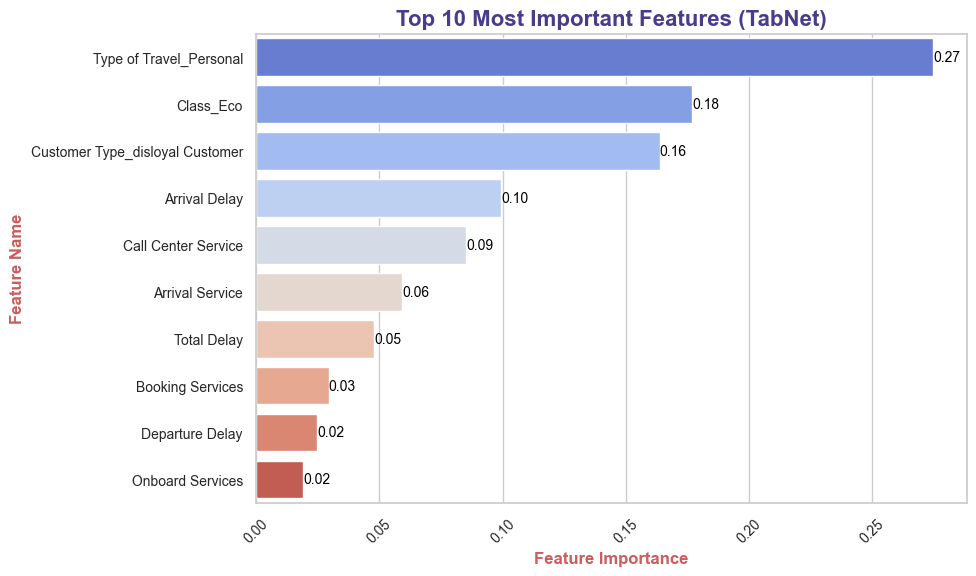

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier

df = pd.read_csv("balanced_dataset.csv")

# Drop unwanted columns
df = data.drop(columns=["Unnamed: 21", "Unnamed: 22"], errors='ignore')

# Step 2: Split dataset into features (X) and target (y)
X = df.drop("Satisfaction_Satisfied", axis=1)  # Replace 'Satisfaction_Satisfied' with your target column
y = df["Satisfaction_Satisfied"]

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Convert to numpy arrays for TabNet
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
y_train_np = y_train.values.astype(np.int64)
y_test_np = y_test.values.astype(np.int64)

# (Assuming your TabNet model is already trained and available as `tabnet_model`)

# Step 5: Get feature importance from TabNet
feature_importances = tabnet_model.feature_importances_

# Step 6: Create DataFrame of feature names and importance
feat_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Step 7: Plot top 10 most important features with sweet colors and formatted labels
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(10), palette='coolwarm')  # Sweet color palette
plt.title('Top 10 Most Important Features (TabNet)', fontsize=16, fontweight='bold', color='darkslateblue')  # Title formatting
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold', color='indianred')  # X-axis label formatting
plt.ylabel('Feature Name', fontsize=12, fontweight='bold', color='indianred')  # Y-axis label formatting
plt.xticks(fontsize=10, rotation=45)  # X-axis ticks formatting
plt.yticks(fontsize=10)  # Y-axis ticks formatting

# Display values on the bars, rounded to two decimal places
for index, value in enumerate(feat_importance_df.head(10)['Importance']):
    plt.text(value, index, f'{value:.2f}', color='black', ha="left", va="center", fontsize=10)

plt.tight_layout()
plt.show()

#### 3. DCN Implementation Using Keras

In [83]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [84]:
data = pd.read_csv("balanced_dataset.csv")
# Drop unwanted columns
data = data.drop(columns=["Unnamed: 21", "Unnamed: 22"], errors='ignore')


In [85]:
data.head()

,Age,Arrival Service,Booking Services,Immediate Transfer,Lounge Service,Check-in Service,Boarding Service,Layover Service,Onboard Services,Baggage Service,...,Call Center Service,Departure Delay,Arrival Delay,Total Delay,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal,Class_Eco,Class_Leisure,Satisfaction_Satisfied
0,1.296579,0.707066,-0.725397,-0.707346,-1.415134,0.710901,-0.724658,1.419690,-0.713449,1.426085,...,-0.000036,-0.512057,-0.422668,-0.503673,False,False,False,False,False,1
1,0.370184,1.410824,-1.432411,-0.000954,-0.000071,0.007665,-1.432021,0.007274,-0.004924,1.426085,...,-1.419386,0.502862,82.010552,49.503660,False,False,False,False,False,1
2,0.298923,0.003308,-1.432411,-1.413738,0.707461,0.710901,-0.017295,0.007274,-0.004924,1.426085,...,1.419315,-0.512057,-0.422668,-0.503673,True,False,False,True,False,1
3,-0.057383,1.410824,-1.432411,-0.707346,1.414992,-1.398805,0.690068,-0.698934,-0.713449,0.718877,...,1.419315,-0.512057,-0.422668,-0.503673,False,False,False,False,False,1
4,0.940273,1.410824,-0.018382,-1.413738,1.414992,-0.695570,0.690068,1.419690,-1.421974,-0.695539,...,-0.709711,-0.512057,-0.422668,-0.503673,True,False,False,False,False,1


In [86]:
# Split into features and target
X = data.drop('Satisfaction_Satisfied', axis=1).values
y = data['Satisfaction_Satisfied'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [87]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

data = pd.read_csv("balanced_dataset.csv")

# Drop unwanted columns
data = data.drop(columns=["Unnamed: 21", "Unnamed: 22"], errors='ignore')

# Separate features and label
X = data.drop('Satisfaction_Satisfied', axis=1).values
y = data['Satisfaction_Satisfied'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to correct types
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

# Define the Deep & Cross Network model
class DeepCrossNetwork(models.Model):
    def __init__(self, input_dim, deep_layers, cross_layers):
        super(DeepCrossNetwork, self).__init__()
        
        self.deep_layers = [layers.Dense(units, activation='relu') for units in deep_layers]
        self.cross_layers = [layers.Dense(1, activation='sigmoid') for _ in range(cross_layers)]
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = inputs
        for layer in self.deep_layers:
            x = layer(x)
        for cross_layer in self.cross_layers:
            x = cross_layer(x)
        return self.output_layer(x)

# Build and compile the model
dcn_model = DeepCrossNetwork(input_dim=X_train.shape[1], deep_layers=[128, 64], cross_layers=3)
dcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = dcn_model.fit(X_train, y_train, epochs=100, batch_size=1024, validation_data=(X_test, y_test))

# Evaluate
test_loss, test_accuracy = dcn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict and generate classification report
y_pred_probs = dcn_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Ensure correct shape for y_test
y_test = y_test.flatten()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Satisfied', 'Satisfied']))


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4978 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4989 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5015 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4945 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5007 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4935 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4965 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5017 - loss: 0.6925 - val_accuracy: 0.5000 - 

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


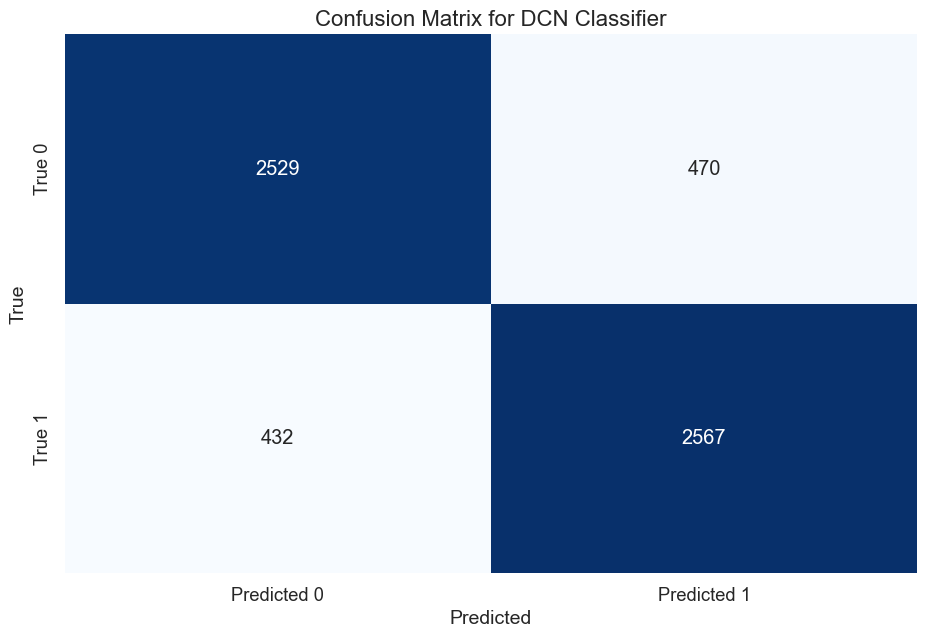

In [88]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Step 1: Predict using the best model
y_pred = dcn_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Step 2: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 3: Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(11, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix for DCN Classifier', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()


#### Classification Report

In [90]:
from sklearn.metrics import classification_report

# Step 6: Generate predictions
y_pred_probs = dcn_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Step 7: Classification report with custom class names
target_names = ['Not Satisfied', 'Satisfied']
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
Classification Report:
               precision    recall  f1-score   support

Not Satisfied       0.85      0.84      0.85      2999
    Satisfied       0.85      0.86      0.85      2999

     accuracy                           0.85      5998
    macro avg       0.85      0.85      0.85      5998
 weighted avg       0.85      0.85      0.85      5998



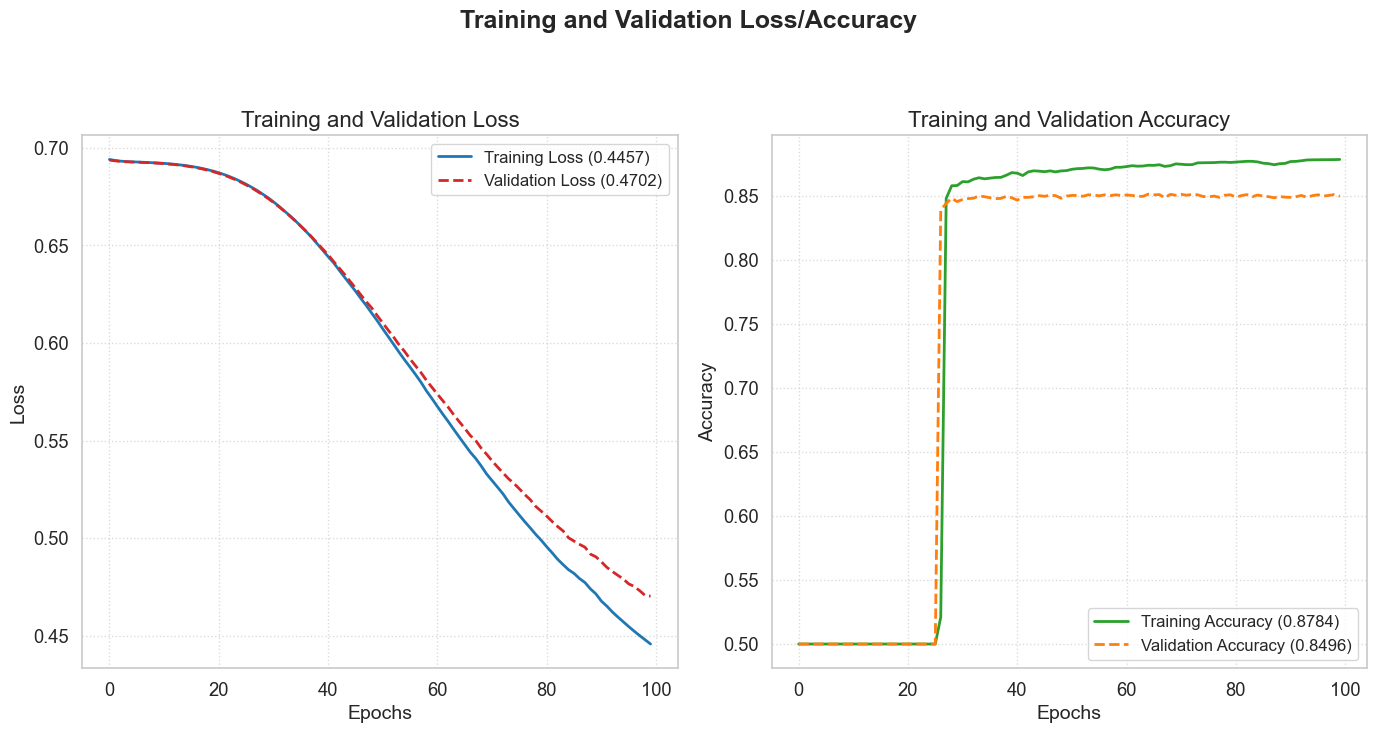

In [91]:
import matplotlib.pyplot as plt

# Step 6: Plot training and validation loss/accuracy
plt.figure(figsize=(14, 7))

# Adding a common title
plt.suptitle('Training and Validation Loss/Accuracy', fontsize=18, y=1.05, fontweight='bold')

# Plotting the loss
plt.subplot(1, 2, 1)
train_loss_line, = plt.plot(history.history['loss'], label=f'Training Loss ({history.history["loss"][-1]:.4f})', color='tab:blue', linewidth=2)
val_loss_line, = plt.plot(history.history['val_loss'], label=f'Validation Loss ({history.history["val_loss"][-1]:.4f})', color='tab:red', linestyle='--', linewidth=2)
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)

# Plotting the accuracy
plt.subplot(1, 2, 2)
train_acc_line, = plt.plot(history.history['accuracy'], label=f'Training Accuracy ({history.history["accuracy"][-1]:.4f})', color='tab:green', linewidth=2)
val_acc_line, = plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy ({history.history["val_accuracy"][-1]:.4f})', color='tab:orange', linestyle='--', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)

# Adjusting layout
plt.tight_layout()

# Show the plots
plt.show()


#### Applying Hyper-parameter Tuning 

In [99]:
# Import necessary libraries
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation
import tensorflow as tf  # TensorFlow for deep learning
from tensorflow.keras import layers, models  # Import Keras layers and model API
import keras_tuner as kt  # Keras Tuner for hyperparameter optimization
from sklearn.model_selection import train_test_split  # For splitting dataset
from sklearn.utils import class_weight  # For computing class weights to handle imbalance

# Load dataset from a CSV file into a pandas DataFrame
data = pd.read_csv("balanced_dataset.csv")

# Drop unwanted columns
data = data.drop(columns=["Unnamed: 21", "Unnamed: 22"], errors='ignore')

# Separate input features (X) and target label (y)
X = data.drop('Satisfaction_Satisfied', axis=1).values.astype(np.float32)  # Drop target column, convert to float32
y = data['Satisfaction_Satisfied'].values.astype(np.int32)  # Extract target column and convert to int32

# Split the dataset into training and testing sets (80/20 split) with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Compute class weights to handle class imbalance in training data
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weights = dict(zip(np.unique(y_train), class_weights_array))  # Convert array to dictionary format

# Define the Deep & Cross Network (DCN) model using subclassing API
class DeepCrossNetwork(models.Model):
    def __init__(self, input_dim, deep_layers, cross_layers):
        super(DeepCrossNetwork, self).__init__()  # Call base class constructor
        # Create deep layers: a list of Dense layers with ReLU activation
        self.deep_layers = [layers.Dense(units, activation='relu') for units in deep_layers]
        # Create cross layers: a list of Dense layers with sigmoid activation (for simplicity)
        self.cross_layers = [layers.Dense(1, activation='sigmoid') for _ in range(cross_layers)]
        # Final output layer with sigmoid activation for binary classification
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = inputs
        # Pass input through deep layers
        for layer in self.deep_layers:
            x = layer(x)
        # Pass the result through cross layers
        for cross_layer in self.cross_layers:
            x = cross_layer(x)
        # Output final prediction
        return self.output_layer(x)

# Define a model builder function for Keras Tuner to optimize hyperparameters
def build_model(hp):
    model = DeepCrossNetwork(
        input_dim=X_train.shape[1],  # Number of input features
        deep_layers=[
            # Search space for first and second deep layer units
            hp.Int('deep_units_1', 32, 512, step=32),
            hp.Int('deep_units_2', 32, 512, step=32)
        ],
        cross_layers=hp.Int('cross_layers', 1, 5)  # Search space for number of cross layers
    )
    model.build((None, X_train.shape[1]))  # Define input shape for the model
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),  # Choose optimizer
        loss='binary_crossentropy',  # Loss function for binary classification
        metrics=['accuracy']  # Track accuracy during training
    )
    return model  # Return compiled model to tuner

# Initialize Keras Tuner with the model builder and search configuration
tuner = kt.Hyperband(
    build_model,  # Function to build the model
    objective='val_accuracy',  # Objective to optimize
    max_epochs=30,  # Maximum number of epochs per trial
    factor=3,  # Reduction factor for epochs in successive halving
    directory='kt_dir',  # Directory to save tuning results
    project_name='dcn_tuning'  # Project name for organizing tuning logs
)

# Start hyperparameter search with training and validation data
tuner.search(
    X_train, y_train,
    epochs=30,  # Number of epochs per trial
    batch_size=1024,  # Batch size for training
    validation_data=(X_test, y_test)  # Validation data
)

# Retrieve the best set of hyperparameters found during tuning
best_hps = tuner.get_best_hyperparameters(1)[0]


Reloading Tuner from kt_dir\dcn_tuning\tuner0.json


In [105]:
# ==============================================
# Imports
# ==============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# ==============================================
# Data Preparation
# ==============================================

# Load dataset
df = pd.read_csv('balanced_dataset.csv')

# Features and target
X = df.drop('Satisfaction_Satisfied', axis=1)
y = df['Satisfaction_Satisfied']

# Drop constant columns
non_constant_cols = X.std(axis=0) > 0
X = X.loc[:, non_constant_cols]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================================
# Model Architecture (Deep & Cross Network)
# ==============================================
def build_deep_cross_network(input_dim, deep_layers, cross_layers):
    inputs = Input(shape=(input_dim,))
    
    # Deep component
    deep = inputs
    for units in deep_layers:
        deep = Dense(units, activation='relu')(deep)
    
    # Cross component
    cross = inputs
    for _ in range(cross_layers):
        cross = Multiply()([inputs, cross])
        cross = Dense(input_dim)(cross)
    
    # Combine
    combined = Concatenate()([deep, cross])
    outputs = Dense(1, activation='sigmoid')(combined)
    
    return Model(inputs=inputs, outputs=outputs)

# ==============================================
# Hyperparameter Tuning
# ==============================================
def model_builder(hp):
    input_dim = X_train.shape[1]
    
    deep_layers = [
        hp.Int('deep_units_1', min_value=32, max_value=256, step=32),
        hp.Int('deep_units_2', min_value=32, max_value=128, step=32)
    ]
    cross_layers = hp.Int('cross_layers', 1, 3)
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
    model = build_deep_cross_network(input_dim, deep_layers, cross_layers)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='tuning',
    project_name='airline_satisfaction'
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Search
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")



Reloading Tuner from tuning\airline_satisfaction\tuner0.json

Best Hyperparameters:
num_layers: 3
units_0: 64
dropout_0: 0.2
learning_rate: 0.001
units_1: 96
dropout_1: 0.4
units_2: 160
dropout_2: 0.5
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0048


In [107]:
# Safe extraction with fallback defaults
best_values = best_hps.values

deep_units_1 = best_values['deep_units_1'] if 'deep_units_1' in best_values else 128
deep_units_2 = best_values['deep_units_2'] if 'deep_units_2' in best_values else 64
cross_layers = best_values['cross_layers'] if 'cross_layers' in best_values else 2
learning_rate = best_values['learning_rate'] if 'learning_rate' in best_values else 1e-3


# ==============================================
# Final Model Training
# ==============================================

# Class weights
class_weights = dict(enumerate(compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)))
print("\nClass Weights:", class_weights)

# Build and compile final model
final_model = build_deep_cross_network(
    input_dim=X_train.shape[1],
    deep_layers=[deep_units_1, deep_units_2],
    cross_layers=cross_layers
)

final_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train
history = final_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=1024,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6348 - loss: 0.6780 - val_accuracy: 0.8163 - val_loss: 0.4672
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8139 - loss: 0.4465 - val_accuracy: 0.8329 - val_loss: 0.4118
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8289 - loss: 0.4162 - val_accuracy: 0.8361 - val_loss: 0.3978
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8392 - loss: 0.5451 - val_accuracy: 0.8394 - val_loss: 0.3990
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8399 - loss: 0.4003 - val_accuracy: 0.8389 - val_loss: 0.3954
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8429 - loss: 0.3932 - val_accuracy: 0.8421 - val_loss: 0.3916
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8474 - loss: 0.3848 - val_accuracy: 0.8413 - val_loss: 0.3892
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - 

In [115]:
# ==============================================
# Evaluation
# ==============================================

# Predictions
y_pred_probs = final_model.predict(X_test)

# Find best threshold
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = [f1_score(y_test, (y_pred_probs > t).astype(int)) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nOptimal threshold: {best_threshold:.4f}, Best F1-score: {best_f1:.4f}")

# Final predictions
y_pred = (y_pred_probs > best_threshold).astype(int).flatten()

# Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Satisfied', 'Satisfied']))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_probs):.4f}")
print(f"Final Accuracy: {accuracy_score(y_test, y_pred):.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step

Optimal threshold: 0.4429, Best F1-score: 0.8547

Classification Report:
               precision    recall  f1-score   support

Not Satisfied       0.87      0.83      0.85      2999
    Satisfied       0.83      0.88      0.85      2999

     accuracy                           0.85      5998
    macro avg       0.85      0.85      0.85      5998
 weighted avg       0.85      0.85      0.85      5998


ROC AUC Score: 0.9174
Final Accuracy: 0.8511


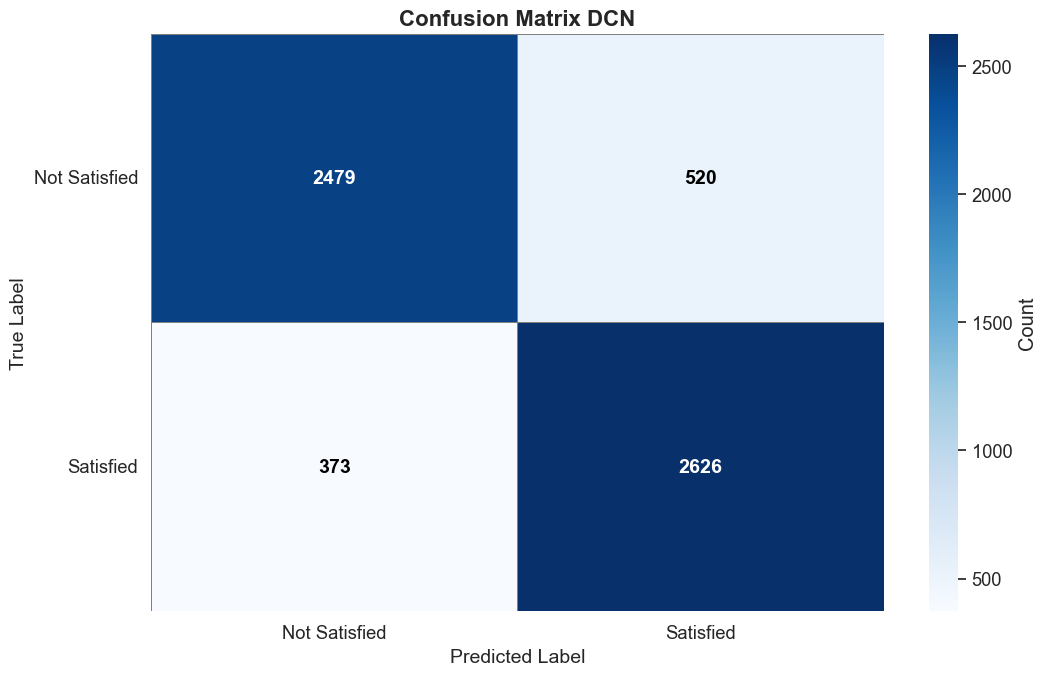

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from matplotlib.colors import Normalize

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Not Satisfied', 'Satisfied']

plt.figure(figsize=(11,7))

# Create the heatmap without annotations first
ax = sns.heatmap(
    cm,
    annot=False,
    fmt='',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={'label': 'Count'},
    linewidths=0.5,
    linecolor='gray'
)

# Normalize counts to [0,1] for color intensity mapping
norm = Normalize(vmin=cm.min(), vmax=cm.max())

# Loop over data dimensions and create text annotations with color adjustment
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        color_val = norm(count)
        # Threshold to decide text color - dark background = white text, else black
        text_color = 'white' if color_val > 0.5 else 'black'
        ax.text(
            j + 0.5, i + 0.5, f"{count}",
            ha='center', va='center',
            fontsize=14,
            fontweight='bold',
            color=text_color
        )

plt.title('Confusion Matrix DCN', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


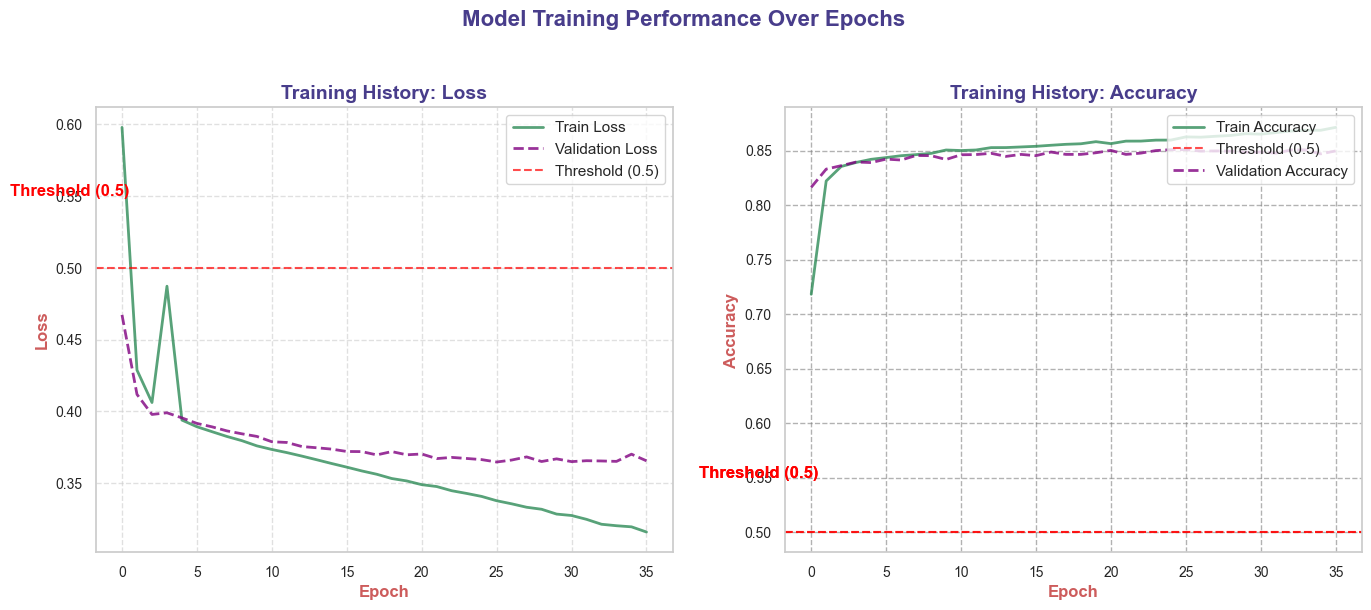

In [129]:
import matplotlib.pyplot as plt

# ==============================================
# Visualization: Training Loss and Accuracy
# ==============================================

plt.figure(figsize=(14, 6))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='seagreen', linewidth=2, alpha=0.8, linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='purple', linewidth=2, alpha=0.8, linestyle='--')
plt.axhline(y=0.5, color='red', linestyle='--', label='Threshold (0.5)', alpha=0.7)
plt.title('Training History: Loss', fontsize=14, fontweight='bold', color='darkslateblue')
plt.text(
    x=0.5, y=0.55,
    s='Threshold (0.5)',
    color='red',
    fontsize=12,
    ha='right',
    fontweight='bold'
)
plt.xlabel('Epoch', fontsize=12, fontweight='bold', color='indianred')
plt.xticks(fontsize=10)
plt.ylabel('Loss', fontsize=12, fontweight='bold', color='indianred')
plt.yticks(fontsize=10)
plt.legend(fontsize=11, loc='upper right')
plt.title('Training History: Loss', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='seagreen', linewidth=2, alpha=0.8)
plt.axhline(y=0.5, color='red', linestyle='--', label='Threshold (0.5)', alpha=0.7)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='purple', linewidth=2, alpha=0.8, linestyle='--')
plt.title('Training History: Accuracy', fontsize=14, fontweight='bold', color='darkslateblue')
plt.text(
    x=0.5, y=0.55,
    s='Threshold (0.5)',
    color='red',
    fontsize=12,
    ha='right',
    fontweight='bold'
)
plt.xlabel('Epoch', fontsize=12, fontweight='bold', color='indianred')
plt.xticks(fontsize=10)
plt.ylabel('Accuracy', fontsize=12, fontweight='bold', color='indianred')
plt.yticks(fontsize=10)
plt.legend(fontsize=11, loc='upper right')
plt.title('Training History: Accuracy', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6, color='gray')
plt.axhline(y=0.5, color='red', linestyle='--', label='Threshold (0.5)', alpha=0.7)

plt.suptitle('Model Training Performance Over Epochs', fontsize=16, fontweight='bold', y=1.02, color='darkslateblue')
plt.text(
    x=0.5, y=0.55,
    s='Threshold (0.5)',
    color='red',
    fontsize=12,
    ha='right',
    fontweight='bold'
)
plt.tight_layout()
plt.show()


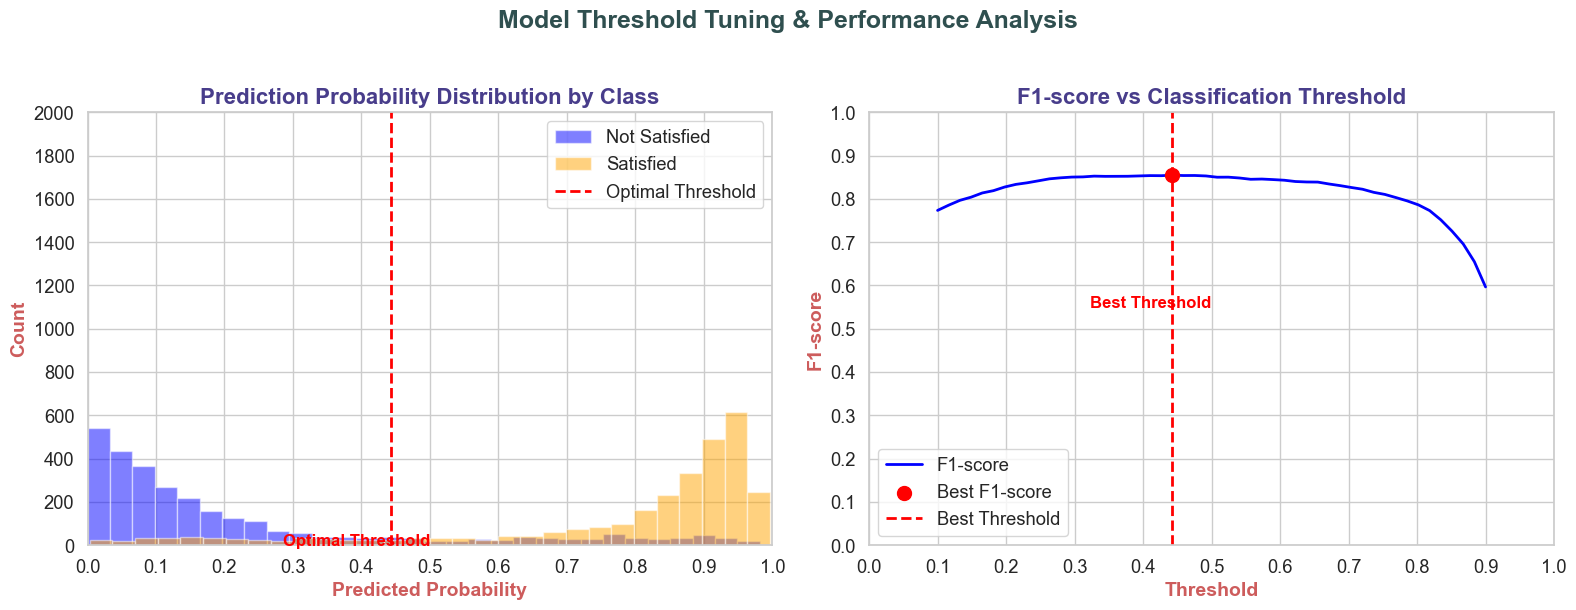

In [131]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Probability Distribution
axs[0].hist(y_pred_probs[y_test == 0], bins=30, alpha=0.5, label='Not Satisfied', color='blue')
axs[0].hist(y_pred_probs[y_test == 1], bins=30, alpha=0.5, label='Satisfied', color='orange')
axs[0].axvline(best_threshold, color='red', linestyle='--', label='Optimal Threshold', linewidth=2)
axs[0].set_xlim(0, 1)
axs[0].set_title('Prediction Probability Distribution by Class', fontsize=16, fontweight='bold', color='darkslateblue')
axs[0].text(
    x=0.5, y=0.55,
    s='Optimal Threshold',
    color='red',
    fontsize=12,
    ha='right',
    fontweight='bold'
)
axs[0].set_xlabel('Predicted Probability', fontsize=14, fontweight='bold', color='indianred')
axs[0].set_xticks(np.arange(0, 1.1, 0.1))
axs[0].set_ylabel('Count', fontsize=14, fontweight='bold', color='indianred')
axs[0].set_yticks(np.arange(0, 2001, 200))
axs[0].legend()

# Subplot 2: F1-score vs Threshold
axs[1].plot(thresholds, f1_scores, label='F1-score', color='blue', linewidth=2)
axs[1].scatter(thresholds[best_idx], best_f1, color='red', s=100, label='Best F1-score', zorder=5)
axs[1].axvline(best_threshold, color='red', linestyle='--', label='Best Threshold', linewidth=2)
axs[1].set_xlim(0, 1)
axs[1].set_title('F1-score vs Classification Threshold', fontsize=16, fontweight='bold', color='darkslateblue')
axs[1].text(
    x=0.5, y=0.55,
    s='Best Threshold',
    color='red',
    fontsize=12,
    ha='right',
    fontweight='bold'
)
axs[1].set_xlabel('Threshold', fontsize=14, fontweight='bold', color='indianred')
axs[1].set_xticks(np.arange(0, 1.1, 0.1))
axs[1].set_ylabel('F1-score', fontsize=14, fontweight='bold', color='indianred')
axs[1].set_yticks(np.arange(0, 1.1, 0.1))
axs[1].grid(True)
axs[1].legend()

# Add a common overall title
fig.suptitle('Model Threshold Tuning & Performance Analysis', fontsize=18, fontweight='bold', color='darkslategray', y=1.02)

plt.tight_layout()
plt.show()


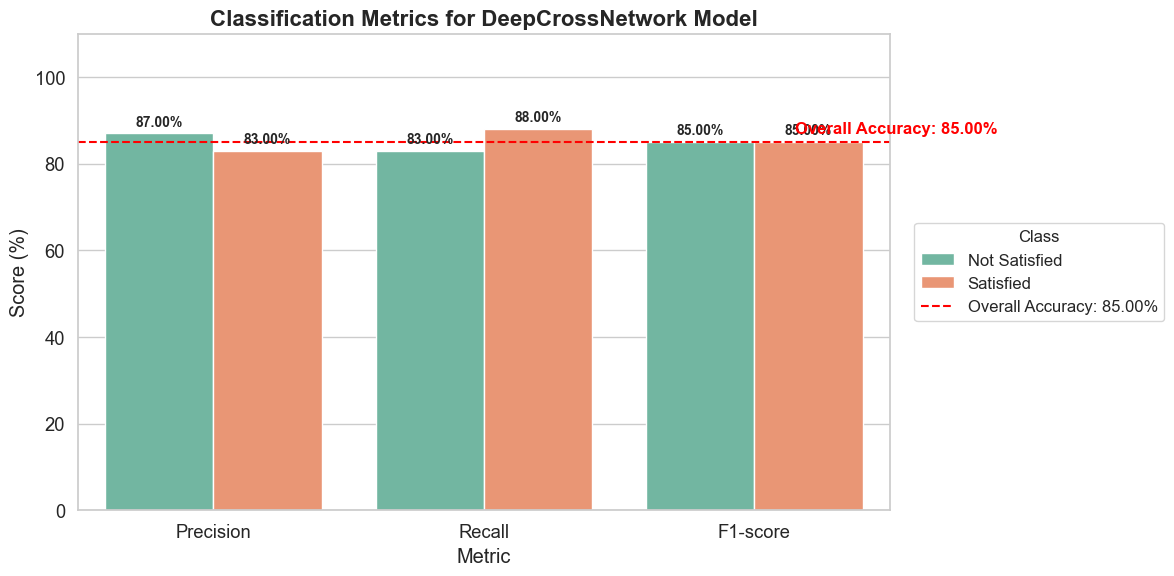

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Updated metrics from the new classification report
metrics = {
    'Class': ['Not Satisfied', 'Not Satisfied', 'Not Satisfied', 'Satisfied', 'Satisfied', 'Satisfied'],
    'Metric': ['Precision', 'Recall', 'F1-score'] * 2,
    'Score': [0.87, 0.83, 0.85, 0.83, 0.88, 0.85]  # Updated scores
}

# Overall accuracy from classification report
accuracy = 0.85
accuracy_percent = accuracy * 100
accuracy_label = f'Overall Accuracy: {accuracy_percent:.2f}%'

# Create DataFrame
class_metrics = pd.DataFrame(metrics)
class_metrics['Score'] = class_metrics['Score'] * 100  # Convert to percentage

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=class_metrics, x='Metric', y='Score', hue='Class', palette='Set2')

# Add score labels on top of bars
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        ax.text(x, height + 1, f'{height:.2f}%', ha='center', va='bottom', fontsize=10, weight='bold')

# Add horizontal accuracy line and label
plt.axhline(accuracy_percent, color='red', linestyle='--', linewidth=1.5, label=accuracy_label)
plt.text(
    x=2.9, y=accuracy_percent + 2,
    s=accuracy_label,
    color='red',
    fontsize=12,
    ha='right',
    fontweight='bold'
)

# Final touches
plt.ylim(0, 110)
plt.title('Classification Metrics for DeepCrossNetwork Model', fontsize=16, fontweight='bold')
plt.ylabel('Score (%)')
plt.xlabel('Metric')
plt.legend(title='Class', loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12, title_fontsize=12, frameon=True)
plt.tight_layout()
plt.show()


#### Model Interpretablity For DCN

In [ ]:
### SHAP Analysis for Model Interpretability

# Create a SHAP explainer using the trained model
explainer = shap.KernelExplainer(final_model.predict, X_train[:100])  # Using a subset of training data for efficiency

# Get SHAP values
shap_values = explainer.shap_values(X_test)

# Plot summary plot for feature importance
shap.summary_plot(shap_values[1], X_test, plot_type="bar")  # Plot feature importance for class 1 (satisfied)

# Plot SHAP dependence plot for a specific feature (e.g., the most important one)
most_important_feature = X_train.columns[np.argmax(np.abs(shap_values[1]).mean(axis=0))]
shap.dependence_plot(most_important_feature, shap_values[1], X_test)

# Plot SHAP values for a single instance
shap.initjs()  # Initializes JavaScript for visualizations
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/4000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━

#### Visualizing the Over all Accuracy of Selected DL Algorithm

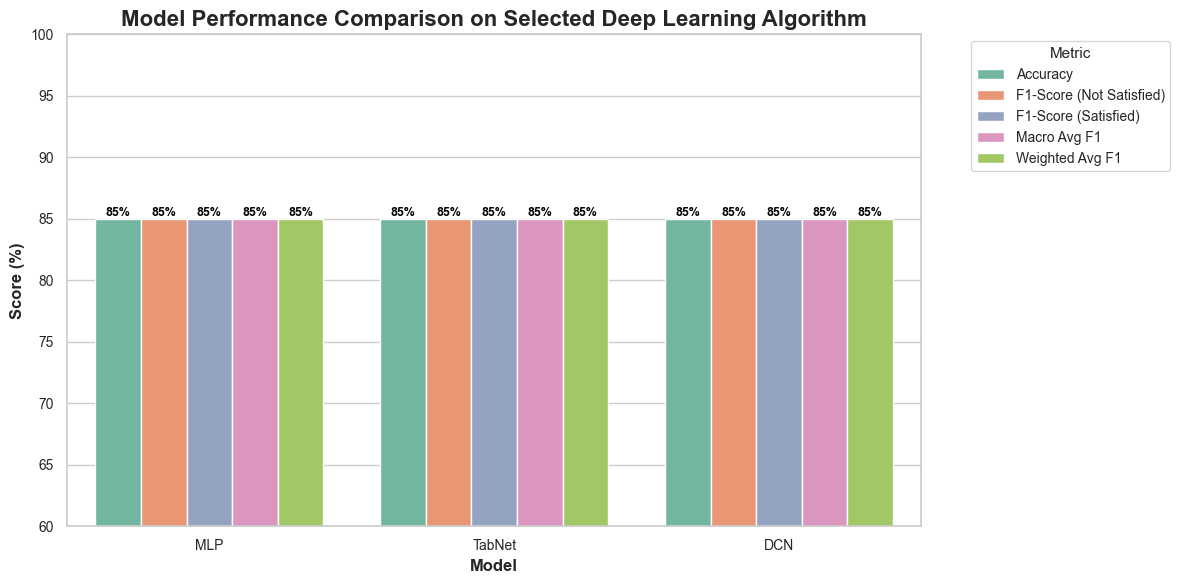

In [134]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set up the data
data = {
    "Model": ["MLP", "TabNet", "DCN"],
    "Accuracy": [85, 85, 85],
    "F1-Score (Not Satisfied)": [85, 85, 85],
    "F1-Score (Satisfied)": [85, 85, 85],
    "Macro Avg F1": [85, 85, 85],
    "Weighted Avg F1": [85, 85, 85]
}

df = pd.DataFrame(data)

# Melt the DataFrame for easier plotting
df_melted = df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Set up the plot aesthetics
sns.set(style="whitegrid")
palette = sns.color_palette("Set2")

# Create the barplot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x="Model", y="Score", hue="Metric", data=df_melted, palette=palette)

# Add values on top of each bar
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.0f}%', 
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

# Add titles and labels
plt.title("Model Performance Comparison on Selected Deep Learning Algorithm", fontsize=16, weight='bold')
plt.ylabel("Score (%)", fontsize=12, weight='bold')
plt.xlabel("Model", fontsize=12, weight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(60, 100)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=11)
plt.tight_layout()

# Show plot
plt.show()
